In [317]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [318]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_historical.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3546669014.py:2: DtypeWarning: Columns (16,17,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(president_polls_url)


In [321]:
df.columns

Index(['Unnamed: 0', 'poll_id', 'pollster_id', 'pollster', 'sponsor_ids',
       'sponsors', 'display_name', 'pollster_rating_id',
       'pollster_rating_name', 'numeric_grade', 'pollscore', 'methodology',
       'transparency_score', 'state', 'start_date', 'end_date',
       'sponsor_candidate_id', 'sponsor_candidate', 'sponsor_candidate_party',
       'endorsed_candidate_id', 'endorsed_candidate_name',
       'endorsed_candidate_party', 'question_id', 'sample_size', 'population',
       'subpopulation', 'population_full', 'tracking', 'created_at', 'notes',
       'url', 'source', 'internal', 'partisan', 'race_id', 'cycle',
       'office_type', 'seat_number', 'seat_name', 'election_date', 'stage',
       'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round',
       'party', 'answer', 'candidate_id', 'candidate_name', 'pct'],
      dtype='object')

In [319]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3189127009.py:1: DtypeWarning: Columns (17,18,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/raw/president_polls_historical.csv")


In [308]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [309]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [310]:
df['date'] = df.median_date
#df['date'] = df.end_date
#df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [311]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [312]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['answer']) == {'Trump', 'Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

#df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [313]:
df = df_2way
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

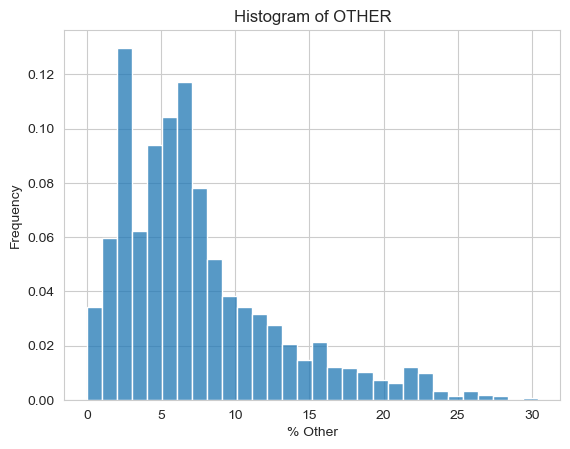

In [10]:
bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Histogram of OTHER')
plt.show()

In [11]:
df = df.query("OTHER > 0")

In [12]:
df.head(20)

,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,election_date,date,year,month,day,week,DEM,GOP,type,obs_id,OTHER
0,73830,138491,940,Lake Research,Live Phone,US,lv,2400.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.510,0.480,2way,0,0.010
1,74946,142781,1677,The Political Matrix/The Listener Group,IVR,FL,lv,966.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.442,0.480,2way,1,0.078
2,72621,136283,383,PPP,IVR/Text,IA,v,871.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.490,0.480,2way,2,0.030
3,72647,136322,461,Susquehanna,Live Phone,PA,lv,499.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.484,0.492,2way,3,0.024
4,72722,136491,235,InsiderAdvantage,IVR/Live Phone,FL,lv,400.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.470,0.482,2way,4,0.048
5,72652,136338,1478,Research Co.,Online Panel,US,lv,1025.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.500,0.420,2way,5,0.080
6,72714,136474,568,YouGov,Online Panel,US,rv,1500.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.490,0.400,2way,6,0.110
7,72714,136475,568,YouGov,Online Panel,US,lv,1363.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.530,0.430,2way,7,0.040
8,72717,136485,241,Ipsos,Probability Panel,US,a,1333.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.510,0.460,2way,8,0.030
9,72717,136486,241,Ipsos,Probability Panel,US,rv,1146.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.520,0.450,2way,9,0.030


Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [13]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,6137.000000,6137.000000
mean,0.502088,0.446828
std,0.077845,0.079647
min,0.214800,0.050000
25%,0.460000,0.410000
50%,0.500000,0.440000
75%,0.530000,0.481000
max,0.940000,0.782800


In [14]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.query("state == 'US'").groupby('pollster').size().sort_values(ascending=False).head(20).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.query("state == 'US'").groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.query("state == 'US'").groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

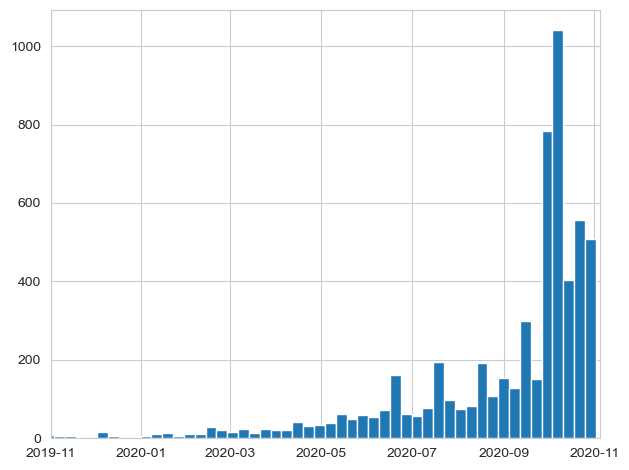

In [15]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2019, 11, 1), dt.datetime(2020, 11, 5))

plt.tight_layout()
plt.show()

In [16]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,IVR/Text,Live Phone/Online Panel,IVR/Online Panel,Text-to-Web/Online Ad,Online Ad,Online Panel/Text-to-Web,Online Panel/Online Ad
pollster,,,,,,,,,,,
All,6036,4006,728,411,117,111,109,106,57,50,50
SurveyMonkey,2840,2840,0,0,0,0,0,0,0,0,0
Morning Consult,466,466,0,0,0,0,0,0,0,0,0
USC Dornsife,214,0,0,214,0,0,0,0,0,0,0
Ipsos,187,1,0,186,0,0,0,0,0,0,0
YouGov,156,156,0,0,0,0,0,0,0,0,0
Change Research,110,2,0,0,0,0,0,106,2,0,0
Data for Progress,96,45,0,0,0,0,0,0,0,50,0
Redfield & Wilton Strategies,94,88,6,0,0,0,0,0,0,0,0


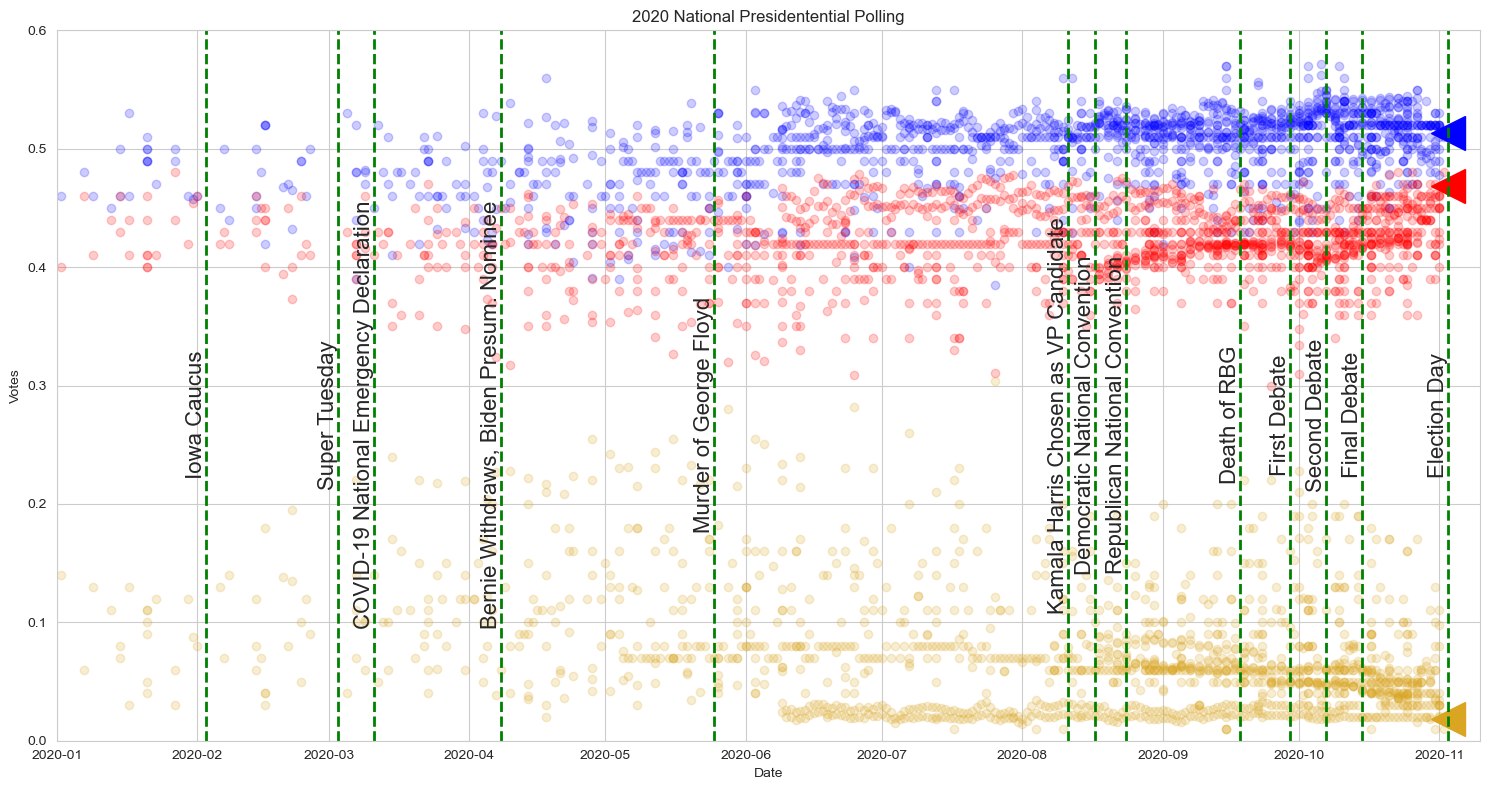

In [17]:
dem_votes = df.query("state == 'US'")["DEM"].values
gop_votes = df.query("state == 'US'")["GOP"].values
oth_votes = df.query("state == 'US'")["OTHER"].values

dates = df.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.2, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .0184, "<", markersize=25, color='goldenrod', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.275, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

In [18]:
df.head(20)

,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,election_date,date,year,month,day,week,DEM,GOP,type,obs_id,OTHER
0,73830,138491,940,Lake Research,Live Phone,US,lv,2400.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.510,0.480,2way,0,0.010
1,74946,142781,1677,The Political Matrix/The Listener Group,IVR,FL,lv,966.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.442,0.480,2way,1,0.078
2,72621,136283,383,PPP,IVR/Text,IA,v,871.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.490,0.480,2way,2,0.030
3,72647,136322,461,Susquehanna,Live Phone,PA,lv,499.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.484,0.492,2way,3,0.024
4,72722,136491,235,InsiderAdvantage,IVR/Live Phone,FL,lv,400.0,2020,11/3/20,2020-11-02,2020,11,-2,-1,0.470,0.482,2way,4,0.048
5,72652,136338,1478,Research Co.,Online Panel,US,lv,1025.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.500,0.420,2way,5,0.080
6,72714,136474,568,YouGov,Online Panel,US,rv,1500.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.490,0.400,2way,6,0.110
7,72714,136475,568,YouGov,Online Panel,US,lv,1363.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.530,0.430,2way,7,0.040
8,72717,136485,241,Ipsos,Probability Panel,US,a,1333.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.510,0.460,2way,8,0.030
9,72717,136486,241,Ipsos,Probability Panel,US,rv,1146.0,2020,11/3/20,2020-11-01,2020,11,-3,-1,0.520,0.450,2way,9,0.030


Text(0.5, 1.0, '30-Day Rolling National Polling Mean')

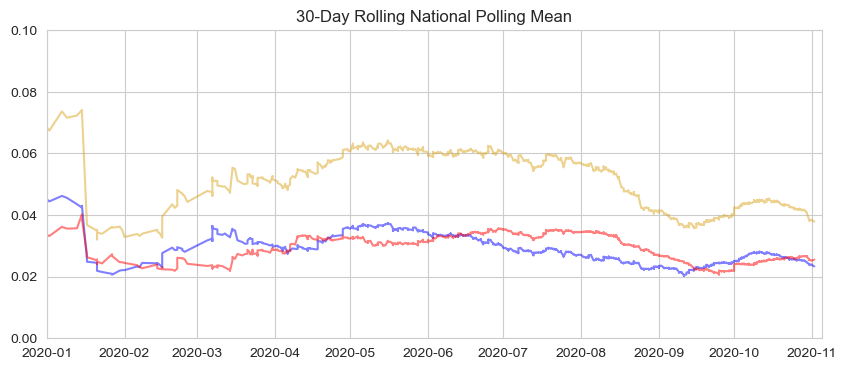

In [19]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .1)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("30-Day Rolling National Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Mean')

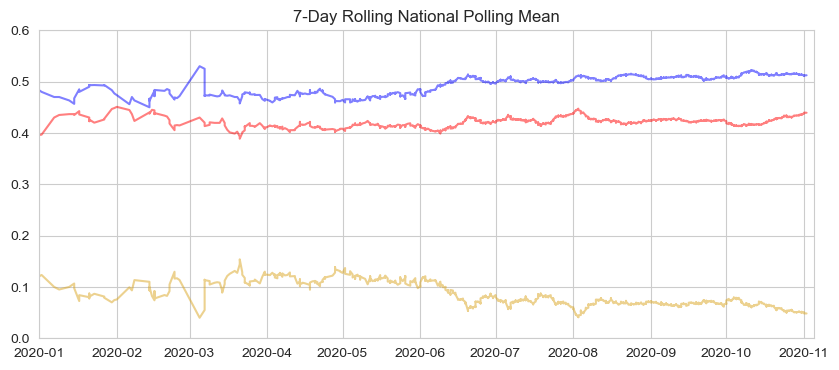

In [20]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Standard Deviation')

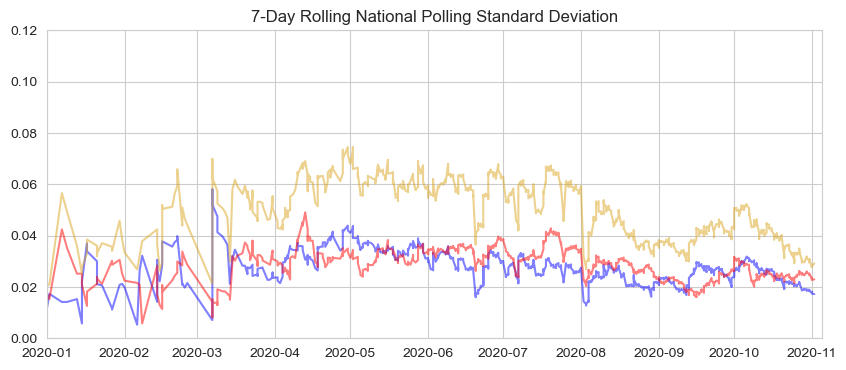

In [21]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .12)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("7-Day Rolling National Polling Standard Deviation")

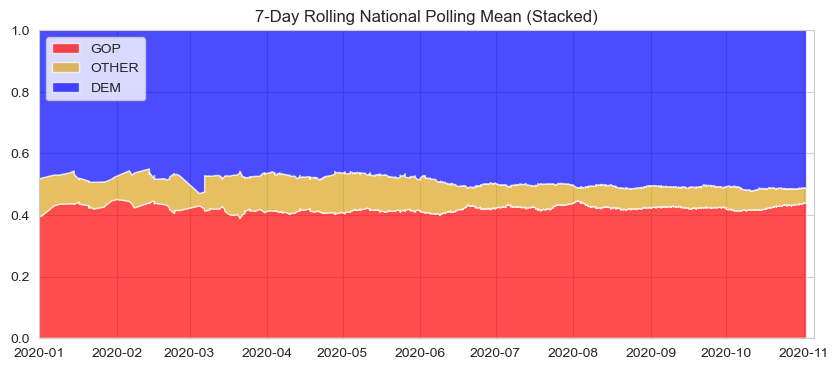

In [22]:
rolling_mean = (
    df.query("state == 'US'")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

We can see here that polling methodology is irrelevant, they all perform about the same.

In [23]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.483850,0.437432
IVR/Text,0.485000,0.410000
Live Phone,0.507911,0.417496
Live Phone/Online Panel,0.499002,0.436913
Online Panel,0.500516,0.426883
Probability Panel,0.501504,0.403252
Text-to-Web/Online Ad,0.497400,0.429920


We can see that Trump fairly consistently under-performs on Probability Panel polls.

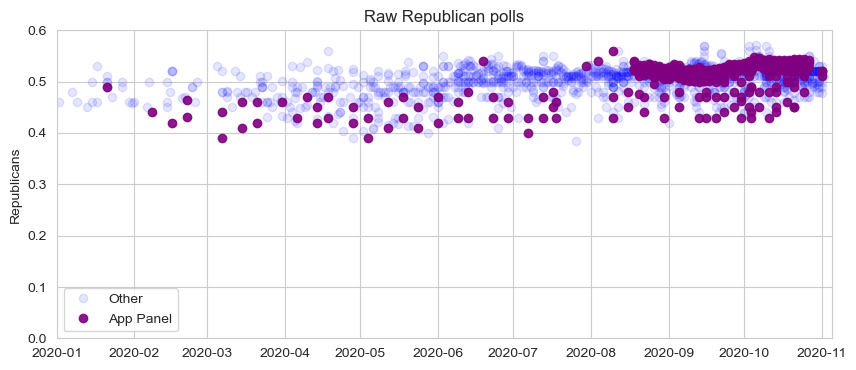

In [24]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "Probability Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "Probability Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["DEM"].values, "o", alpha=0.1, color = 'blue', label="Other")
ax.plot(dates_face, face["DEM"].values, "o", alpha=.9, color = 'purple', label="App Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.legend()

In [25]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2205799714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)


In [26]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,73830,138491,940,Lake Research,Live Phone,US,lv,2400.0,2020,...,2way,0,0.01,0.03,0.46,0.50,0.04,0.02,0.01,-0.01
1,1,74946,142781,1677,The Political Matrix/The Listener Group,IVR,FL,lv,966.0,2020,...,2way,1,0.08,-0.04,0.46,0.50,0.04,0.02,-0.06,-0.08
2,2,72621,136283,383,PPP,IVR/Text,IA,v,871.0,2020,...,2way,2,0.03,0.01,0.46,0.50,0.04,0.02,-0.01,-0.03
3,3,72647,136322,461,Susquehanna,Live Phone,PA,lv,499.0,2020,...,2way,3,0.02,-0.01,0.46,0.50,0.04,0.04,-0.02,-0.05
4,4,72722,136491,235,InsiderAdvantage,IVR/Live Phone,FL,lv,400.0,2020,...,2way,4,0.05,-0.01,0.46,0.50,0.04,0.03,-0.03,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031,6132,57472,93051,1240,Øptimus,Live Phone,US,lv,1064.0,2020,...,2way,6132,0.14,0.04,0.43,0.49,0.06,-0.02,-0.04,-0.01
6032,6133,57427,92926,176,Glengariff Group Inc.,Live Phone,MI,lv,600.0,2020,...,2way,6133,0.06,0.13,0.40,0.53,0.13,0.00,0.00,0.00
6033,6134,57365,92773,383,PPP,IVR/Online Panel,US,rv,760.0,2020,...,2way,6134,0.06,0.12,0.41,0.53,0.12,0.00,0.00,0.00
6034,6135,57275,92597,383,PPP,IVR/Online Panel,NC,rv,750.0,2020,...,2way,6135,0.07,0.05,0.44,0.49,0.05,0.00,0.00,0.00


In [27]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,0.055119


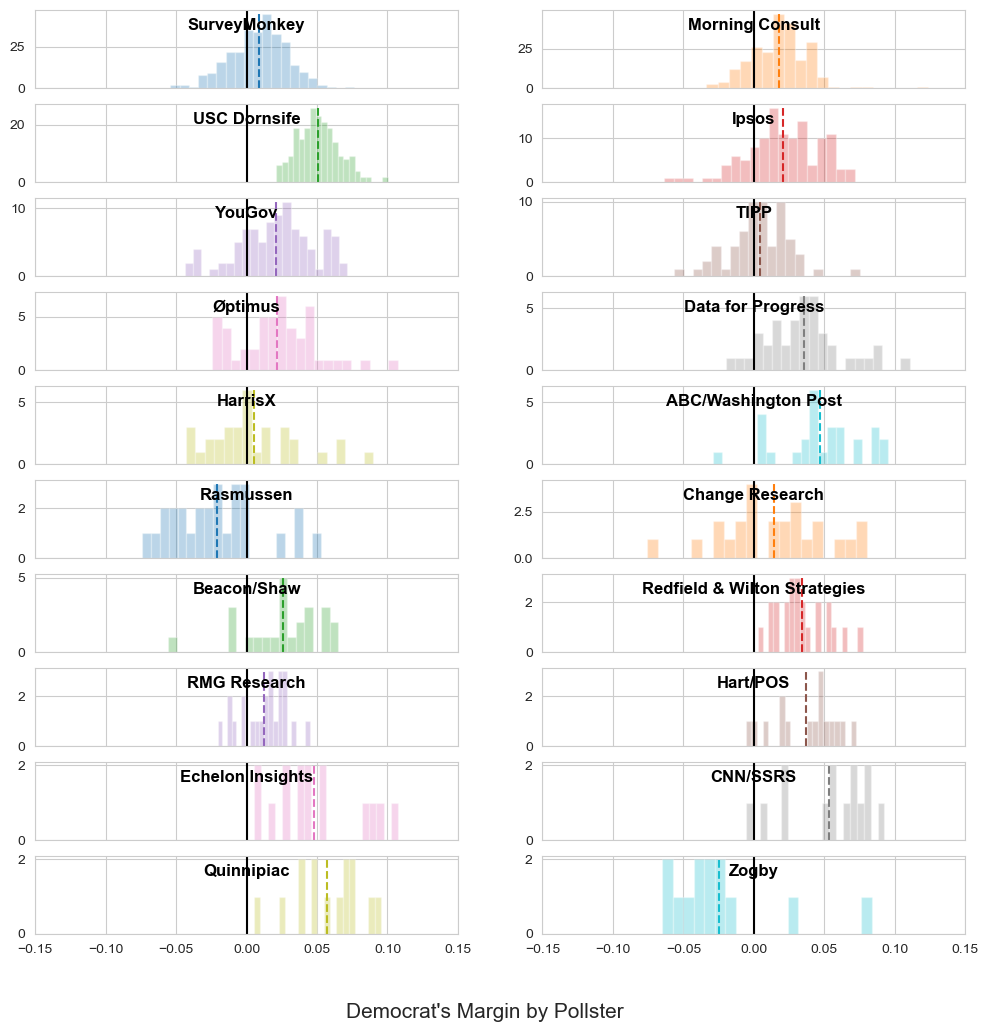

In [28]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=10, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.15, .15)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

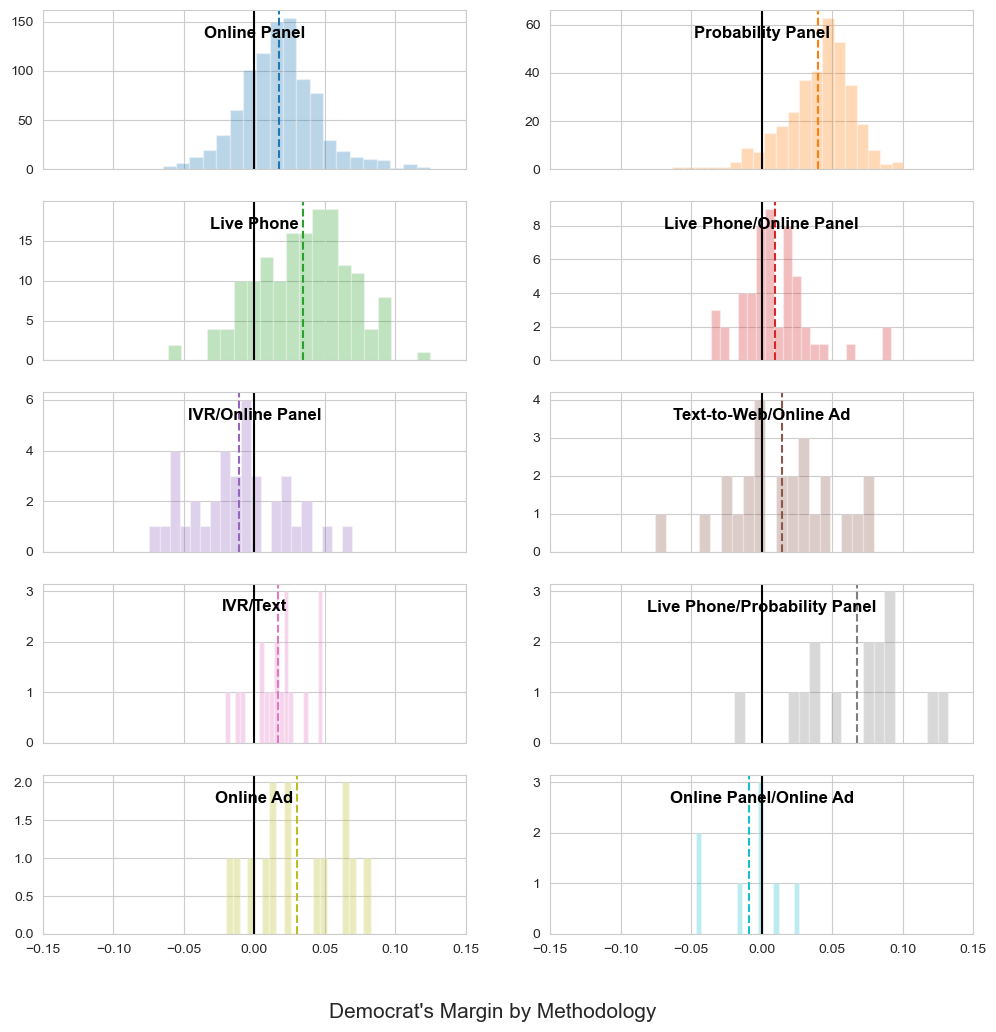

In [29]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in list(METHODS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), METHOD_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.15, .15)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

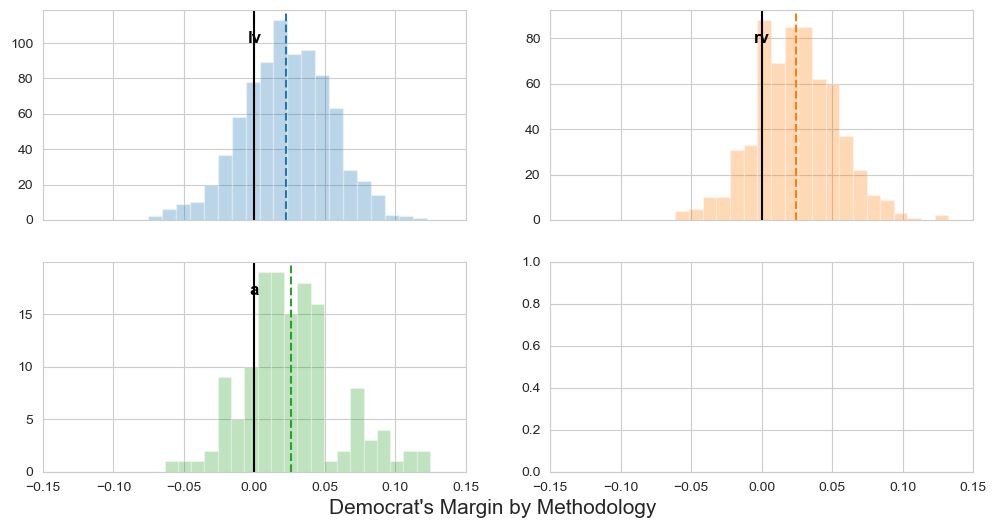

In [30]:
POPULATIONS_VALS = {
    population: df.query("state == 'US'")[df.query("state == 'US'")["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.15, .15)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

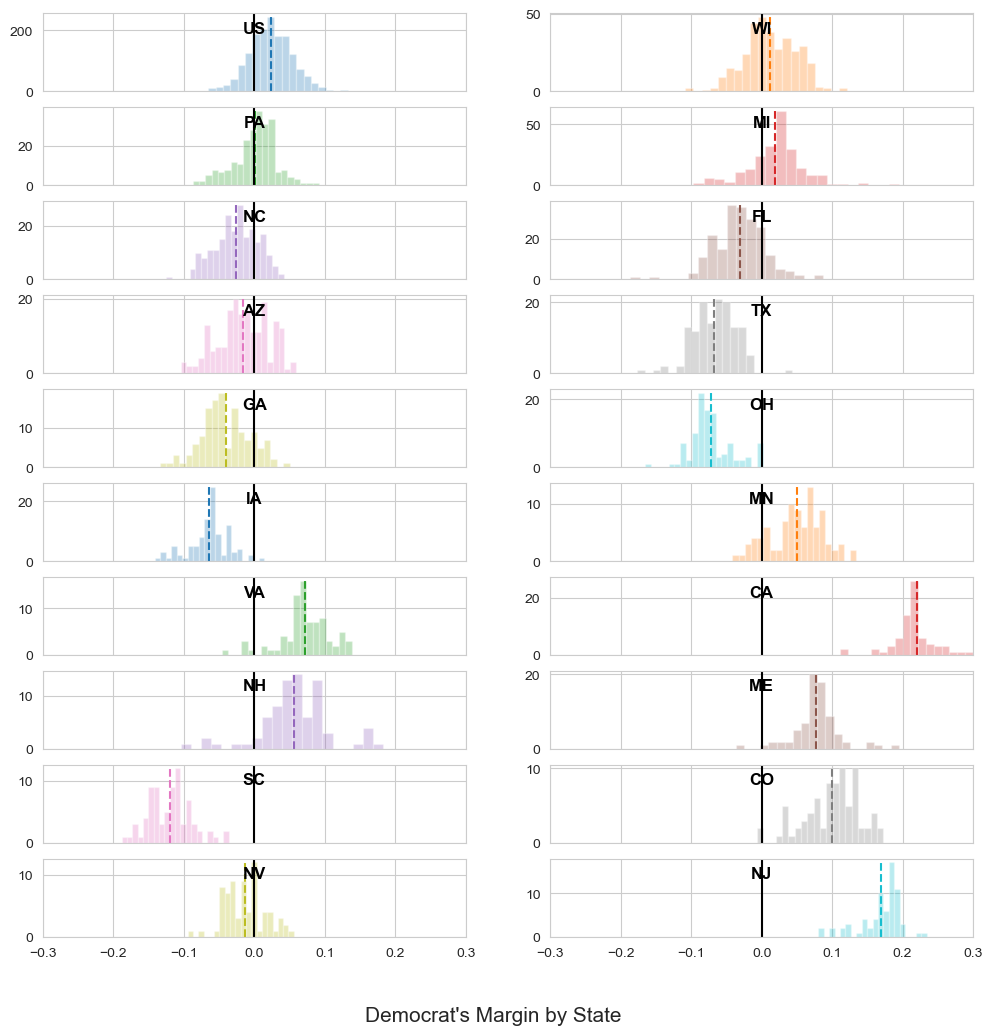

In [31]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=10, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (state, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.30, .30)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, state, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by State", ha='center', fontsize=15)

# Show the plot
plt.show()

In [32]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

print(date_counts.head(10))

        date  count
0 2020-11-02      5
1 2020-11-01     17
2 2020-10-31     56
3 2020-10-30     37
4 2020-10-29     64
5 2020-10-28     15
6 2020-10-27    194
7 2020-10-26    120
8 2020-10-25    168
9 2020-10-24     27


In [33]:
df[['date','pollster',
       'methodology', 'state', 'population', 'sample_size', 'DEM', 'GOP',
       'OTHER', 'margin']].head(20)

,date,pollster,methodology,state,population,sample_size,DEM,GOP,OTHER,margin
0,2020-11-02,Lake Research,Live Phone,US,lv,2400.0,0.510,0.480,0.010,0.030
1,2020-11-02,The Political Matrix/The Listener Group,IVR,FL,lv,966.0,0.442,0.480,0.078,-0.038
2,2020-11-02,PPP,IVR/Text,IA,v,871.0,0.490,0.480,0.030,0.010
3,2020-11-02,Susquehanna,Live Phone,PA,lv,499.0,0.484,0.492,0.024,-0.008
4,2020-11-02,InsiderAdvantage,IVR/Live Phone,FL,lv,400.0,0.470,0.482,0.048,-0.012
5,2020-11-01,Research Co.,Online Panel,US,lv,1025.0,0.500,0.420,0.080,0.080
6,2020-11-01,YouGov,Online Panel,US,rv,1500.0,0.490,0.400,0.110,0.090
7,2020-11-01,YouGov,Online Panel,US,lv,1363.0,0.530,0.430,0.040,0.100
8,2020-11-01,Ipsos,Probability Panel,US,a,1333.0,0.510,0.460,0.030,0.050
9,2020-11-01,Ipsos,Probability Panel,US,rv,1146.0,0.520,0.450,0.030,0.070


In [34]:
df.columns

Index(['field_date', 'poll_id', 'question_id', 'pollster_id', 'pollster',
       'methodology', 'state', 'population', 'sample_size', 'cycle',
       'election_date', 'date', 'year', 'month', 'day', 'week', 'DEM', 'GOP',
       'type', 'obs_id', 'OTHER', 'margin', 'GOP_mean', 'DEM_mean',
       'margin_mean', 'diff_GOP', 'diff_DEM', 'diff_margin'],
      dtype='object')

In [35]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [36]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_fund_dem = pm.Normal("polling_error_fund_dem", 0, .022)
    polling_error_fund_gop = pm.Deterministic("polling_error_fund_gop", -polling_error_fund_dem)
    polling_error_fund_oth = pm.Deterministic("polling_error_fund_oth", polling_error_fund_dem*0)

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, .030, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_fund_dem, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 4389 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


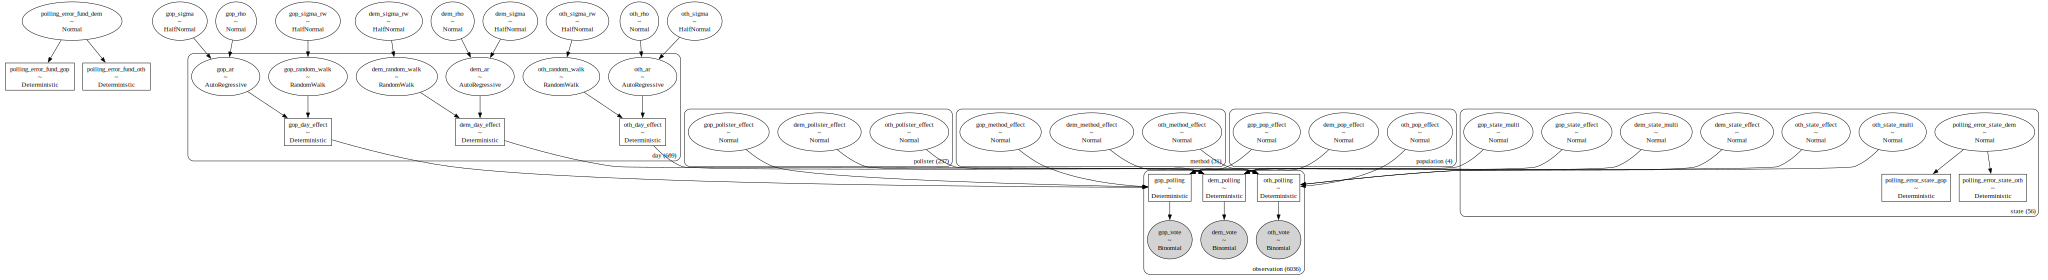

In [37]:
pm.model_to_graphviz(twoway)

In [38]:
z = pd.DataFrame()
z['state'] = idata.posterior.state
z['dem_state_multi'] = idata.posterior.dem_state_multi.mean(axis=0).mean(axis=0).values
z['dem_state_effect'] = idata.posterior.dem_state_effect.mean(axis=0).mean(axis=0).values
z['gop_state_multi'] = idata.posterior.gop_state_multi.mean(axis=0).mean(axis=0).values
z['gop_state_effect'] = idata.posterior.gop_state_effect.mean(axis=0).mean(axis=0).values
z['oth_state_multi'] = idata.posterior.oth_state_multi.mean(axis=0).mean(axis=0).values
z['oth_state_effect'] = idata.posterior.oth_state_effect.mean(axis=0).mean(axis=0).values

In [39]:
z.sort_values(by='dem_state_effect')

,state,dem_state_multi,dem_state_effect,gop_state_multi,gop_state_effect,oth_state_multi,oth_state_effect
55,WY,0.970958,-0.830640,1.041718,0.801338,1.069902,-0.150818
54,WV,0.847404,-0.785965,0.994515,0.775408,1.186648,-0.104883
30,ND,1.038490,-0.520835,1.043789,0.508800,1.068367,-0.336724
40,OK,1.714274,-0.518376,1.873973,0.453972,1.202802,-0.086522
13,ID,1.022492,-0.509955,0.940666,0.478545,0.924069,-0.089015
1,AL,0.936021,-0.506867,0.914933,0.483629,0.928951,-0.116987
2,AR,1.197057,-0.506080,1.328248,0.461063,0.991670,-0.112345
18,LA,0.762878,-0.455566,0.974862,0.406463,0.713183,-0.132138
17,KY,1.376426,-0.454957,1.231755,0.428642,1.409593,0.235770
27,MS,0.624981,-0.448728,0.676429,0.457531,1.098038,-0.113536


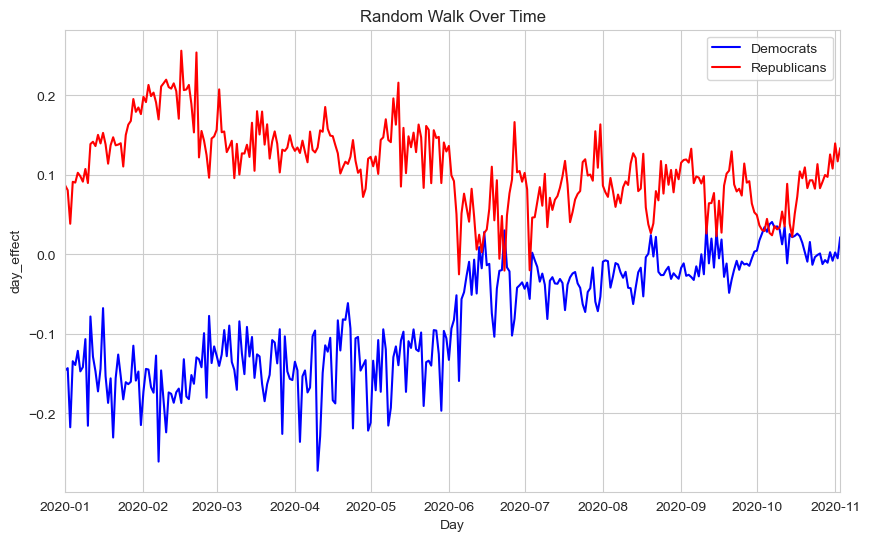

In [40]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.date.min(), end='2020-11-04')
rw['dem'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values
rw['gop'] = idata.posterior.gop_day_effect.mean(axis=0).mean(axis=0).values
rw = rw.set_index('day')

# Creating the figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
ax.plot(rw['dem'], color='blue', label='Democrats', linestyle='-')
ax.plot(rw['gop'], color='red', label='Republicans', linestyle='-')

# Setting labels, title, and grid
ax.set_xlabel('Day')
ax.set_ylabel('day_effect')
ax.set_title('Random Walk Over Time')
ax.grid(True)

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))

# Adding a legend
ax.legend()

# Showing the plot
plt.show()

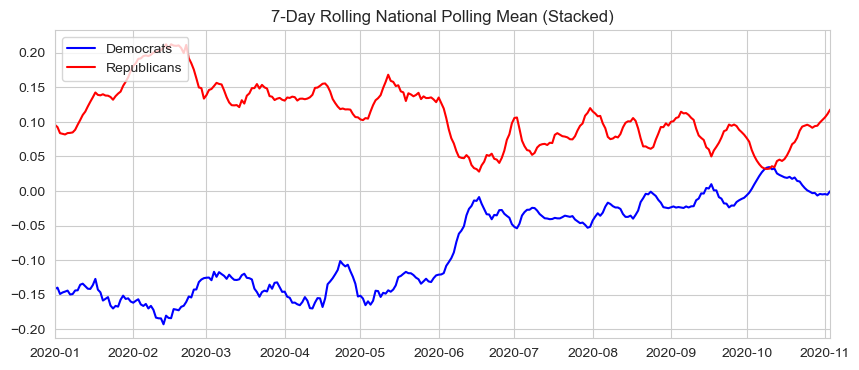

In [41]:
rolling_mean = (
    rw[["gop", "dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["day","gop", "dem"]]
    .dropna()
).set_index('day')

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(rolling_mean['dem'], color='blue', label='Democrats', linestyle='-')
ax.plot(rolling_mean['gop'], color='red', label='Republicans', linestyle='-')

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

In [42]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [111]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos")
    ).values / 5
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    )/2
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_fund_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] + interim[f"polling_error_{party}"]

In [112]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 = pd.DataFrame(index=day, columns=combinations)
df_day_25 = pd.DataFrame(index=day, columns=combinations)
df_day_75 = pd.DataFrame(index=day, columns=combinations)
df_day_97 = pd.DataFrame(index=day, columns=combinations)

#for d in [-18]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            # Calculate the results and store them in the dictionary
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
            ).to_numpy()

        # Adjust the 'oth' results and sum the total
        day_results[f"{state}_dem"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_gop"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_oth"] /= 2

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 689/689 [01:12<00:00,  9.52it/s]


<Axes: >

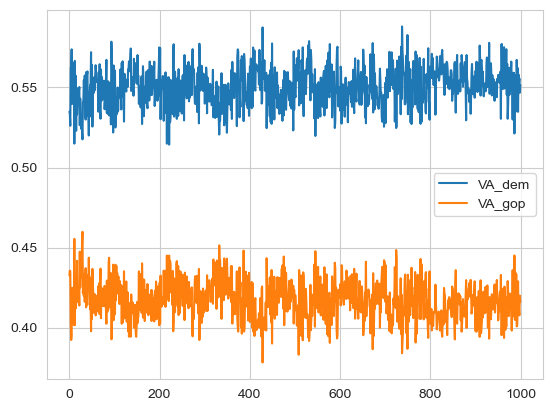

In [113]:
df_results[['VA_dem','VA_gop']].plot()

In [114]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2020-11-04')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [115]:
min(df_day_mean.index)

-688

In [116]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3567373820.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3567373820.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

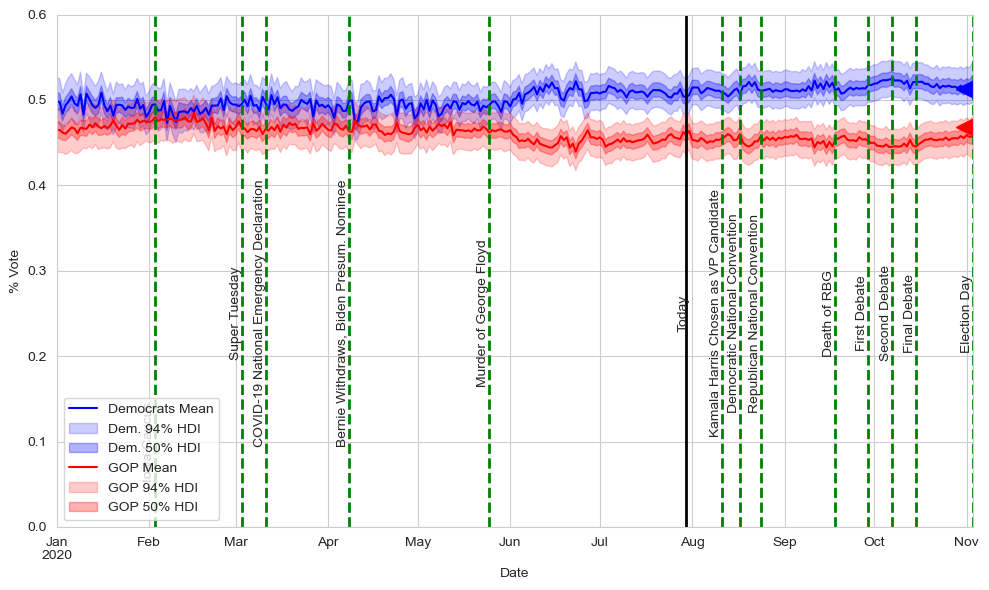

In [117]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020,  3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020,  3,  3), 'Super Tuesday'),
            (dt.datetime(2020,  4,  8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020,  5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020,  8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020,  8, 17), 'Democratic National Convention'),
            (dt.datetime(2020,  8, 24), 'Republican National Convention'),
            (dt.datetime(2020,  9, 18), 'Death of RBG'),
            (dt.datetime(2020,  9, 29), 'First Debate'),
            (dt.datetime(2020, 10,  7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11,  3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 7, 30), color='black', linestyle='-', linewidth=2)
plt.text(dt.datetime(2020, 7, 31), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 2, 3), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2020, 2, 3), 0.1, 'Iowa Caucus', rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/1299690792.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/1299690792.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

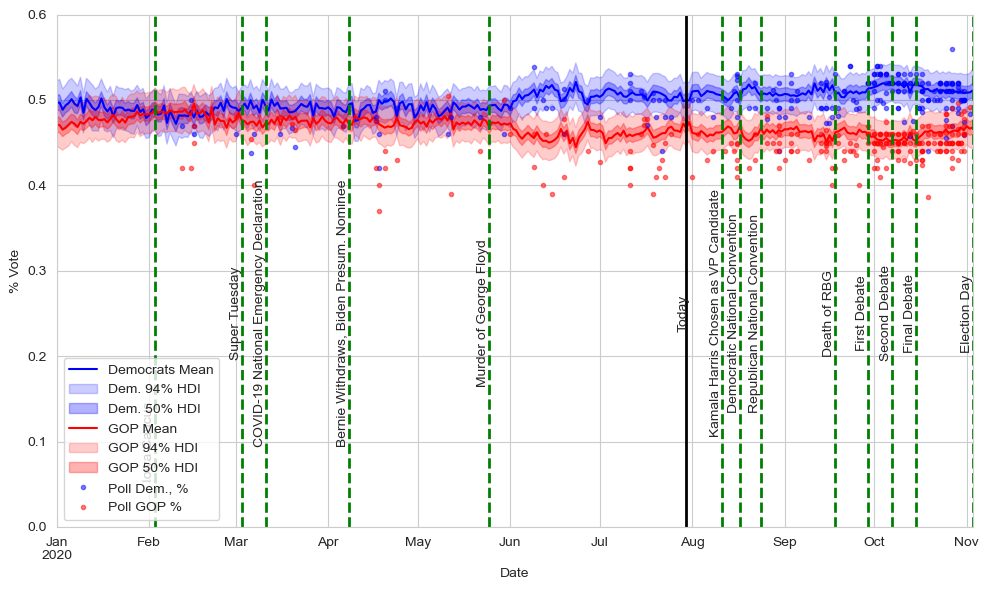

In [118]:
graph_state = 'PA'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 7, 30), color='black', linestyle='-', linewidth=2)
plt.text(dt.datetime(2020, 7, 31), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 2, 3), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2020, 2, 3), 0.1, 'Iowa Caucus', rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.savefig('this_year_zoom.png')

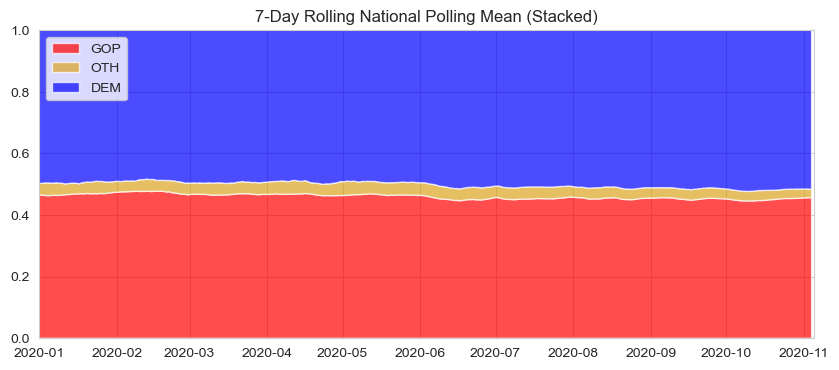

In [119]:
graph_state = 'US'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    1 - rolling_mean[f"{graph_state}_gop"].values - rolling_mean[f"{graph_state}_dem"].values,
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTH", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 5))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

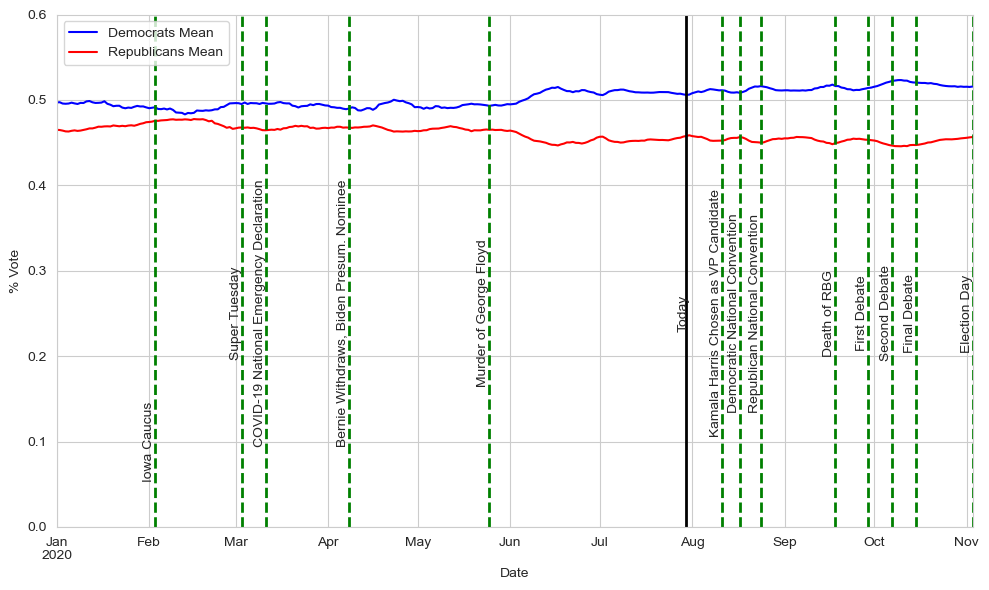

In [120]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].rolling(window='7D').mean().plot(color='blue', label='Democrats Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='7D').mean().plot(color='red', label='Republicans Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 3))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 7, 30), color='black', linestyle='-', linewidth=2)
plt.text(dt.datetime(2020, 7, 31), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 2, 3), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2020, 2, 3), 0.1, 'Iowa Caucus', rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.savefig('past_three_years.png')

In [121]:
# List of states to loop over
state_loop = ['TX', 'CA', 'MN', 'MI', 'FL', 'GA', 'US','WI','PA','AZ','NV','NC', 'NY', 'OH']

# Loop over each state
for state in state_loop:
    graph_state = state
    
    # Create a new figure for each state
    plt.figure(figsize=(10, 6))
    
    # Define the bin edges, ensuring that they align perfectly
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    # Plot the histogram using the pre-defined bins
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    # Get patches from the Axes
    for patch in ax.patches:
        # Get x midpoint of bar
        x = patch.get_x() + 0.5 * patch.get_width()
        
        # Set bar color based on x
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    # Add titles and labels
    plt.title(f'2020 Today - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'2way_enight_{state.lower()}.png')
    
    # Close the figure to avoid overlapping
    plt.close()


In [122]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [123]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

32    NE-3
Name: state_code, dtype: object

In [124]:
#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'NE-2', 'DC']] = 'dem'

#df_winner[['NE-1', 'NE-3']] = 'gop'
#df_winner[['DE','DC']] = 'dem'

df_winner['NE-3'] = df_winner['WY']

state_order = df_state['state_code'].to_list

In [125]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [126]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2020']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2020']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']
df_ec['dem_ec'] = np.where(df_ec['dem'] >= 270, 1, 0)
df_ec['gop_ec'] = np.where(df_ec['gop'] >= 270, 1, 0)
df_ec['tie_ec'] = np.where(df_ec['dem'] == 269, 1, 0)

In [127]:
df_ec

,dem,gop,dem_pop,gop_pop,dem_ec,gop_ec,tie_ec
0,311,227,1,0,1,0,0
1,305,233,1,0,1,0,0
2,305,233,1,0,1,0,0
3,291,247,1,0,1,0,0
4,295,243,1,0,1,0,0
...,...,...,...,...,...,...,...
995,351,187,1,0,1,0,0
996,389,149,1,0,1,0,0
997,322,216,1,0,1,0,0
998,351,187,1,0,1,0,0


In [128]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(94.3, 0.1, 5.6000000000000005)

In [129]:
df_ec[['dem','gop']].max()

dem    414
gop    316
dtype: int64

In [130]:
df_ec[['dem','gop']].min()

dem    222
gop    124
dtype: int64

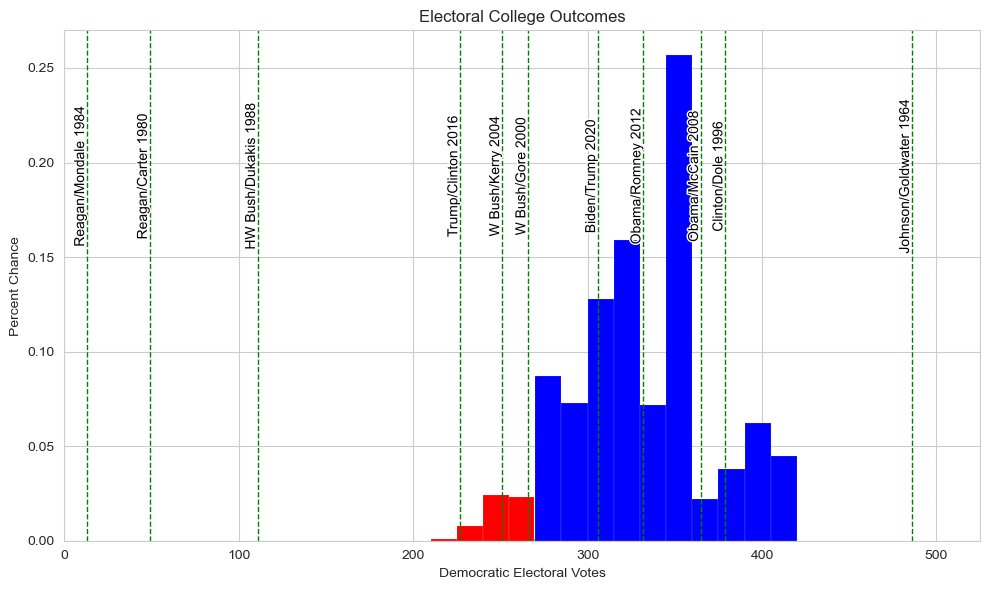

In [184]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 269, 15)) + [269] + list(range(270, 540, 15))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], bins=bins, cumulative=False, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [132]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [133]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win without Popular Vote")
print("-------------------------------------")
print(" Democrats:   " + f"{round(pct_dem_wo_pop,2):6.2f}" + "%")
print(" Republicans: " + f"{round(pct_gop_wo_pop,2):6.2f}" + "%")
print(" Total:       " + f"{round(pct_dem_wo_pop+pct_gop_wo_pop,2):6.2f}" + "%")
print()
print("Popular Vote Estimates")
print("-----------------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% | "+ f"{df_dem.US.quantile(0.03) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.97) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.03) * 100 - df_gop.US.quantile(0.97) * 100, 2):6.2f}")
print(" 25% | "+ f"{df_dem.US.quantile(0.25) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.75) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.25) * 100 - df_gop.US.quantile(0.75) * 100, 2):6.2f}")
print(" 50% | "+ f"{df_dem.US.quantile(0.50) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.50) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.50) * 100 - df_gop.US.quantile(0.50) * 100, 2):6.2f}")
print(" 75% | "+ f"{df_dem.US.quantile(0.75) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.25) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.75) * 100 - df_gop.US.quantile(0.25) * 100, 2):6.2f}")
print(" 97% | "+ f"{df_dem.US.quantile(0.97) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.03) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.97) * 100 - df_gop.US.quantile(0.03) * 100, 2):6.2f}")

% Chance of a Win without Popular Vote
-------------------------------------
 Democrats:     0.40%
 Republicans:   5.00%
 Total:         5.40%

Popular Vote Estimates
-----------------------------
  %  |  DEM  |  GOP  | Margin 
  3% | 49.02 | 48.11 |  0.91
 25% | 50.51 | 46.46 |  4.06
 50% | 51.46 | 45.60 |  5.86
 75% | 52.33 | 44.56 |  7.77
 97% | 54.09 | 43.02 | 11.06


In [134]:
margin_and_ec = pd.DataFrame()
margin_and_ec['pop'] = df_results.US_margin
margin_and_ec['ec'] = df_ec.dem - df_ec.gop

margin_and_ec = margin_and_ec.groupby('ec').agg(
    count=('pop', 'size'),   # Count the occurrences of each unique combination of rows
    pop=('pop', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)

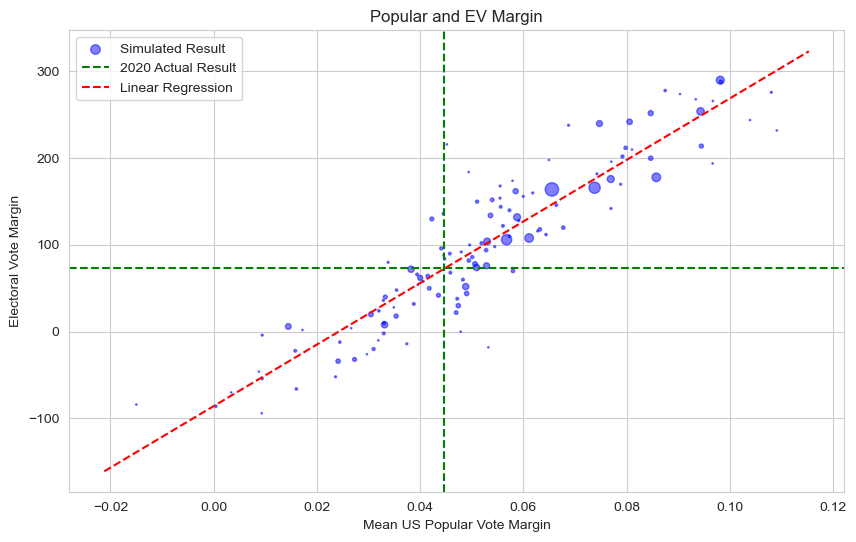

In [135]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(margin_and_ec['pop'], margin_and_ec['ec'], 
            s=margin_and_ec['count'], color='blue', alpha=0.5, label='Simulated Result')

plt.axhline(y=74, color='green', linestyle='--', label='2020 Actual Result')
plt.axvline(x=.0446, color='green', linestyle='--')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(margin_and_ec['pop'], margin_and_ec['ec'])

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

# Add labels and title
plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Vote Margin')
plt.title('Popular and EV Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

In [136]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [137]:
df_win_pct.sort_values('dem')

,dem,gop
NE-3,0.000,1.000
NE,0.000,1.000
MO,0.000,1.000
LA,0.000,1.000
OK,0.000,1.000
KY,0.000,1.000
SD,0.000,1.000
TN,0.000,1.000
UT,0.000,1.000
IN,0.000,1.000


In [138]:
df_mean.sort_values('margin')

,dem,gop,margin,oth
WY,0.307751,0.668944,-0.361193,NaN
WV,0.316977,0.661928,-0.344950,NaN
OK,0.373134,0.606016,-0.232881,NaN
ND,0.377090,0.603289,-0.226199,NaN
AR,0.378438,0.595245,-0.216807,NaN
AL,0.380324,0.591344,-0.211019,NaN
ID,0.379942,0.590802,-0.210860,NaN
KY,0.391083,0.586718,-0.195635,NaN
MS,0.395552,0.581069,-0.185517,NaN
LA,0.391964,0.572068,-0.180104,NaN


In [139]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).mean()
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin = pd.merge(df_margin,df_state[['state_code','electoral_2020']], left_index=True, right_on='state_code')

In [140]:
df_margin

,hdi_03,hdi_25,hdi_mean,hdi_75,hdi_97,state_code,electoral_2020
28,0.009915,0.040083,0.059242,0.077370,0.109095,US,0
8,-0.042228,-0.014518,0.002534,0.019824,0.047629,FL,29
14,-0.072120,-0.041056,-0.023035,-0.004793,0.026149,IA,6
43,-0.010717,0.024301,0.041489,0.059018,0.091337,PA,20
33,-0.027191,0.006429,0.024198,0.043951,0.072503,NV,6
9,-0.038030,-0.009289,0.009916,0.028044,0.060664,GA,16
45,-0.136160,-0.107492,-0.089164,-0.071717,-0.040190,SC,9
31,-0.022271,0.013145,0.035244,0.057114,0.094957,NE-2,1
27,-0.137894,-0.105448,-0.086350,-0.068226,-0.035451,MT,3
18,0.070937,0.101390,0.120415,0.138524,0.170608,ME,2


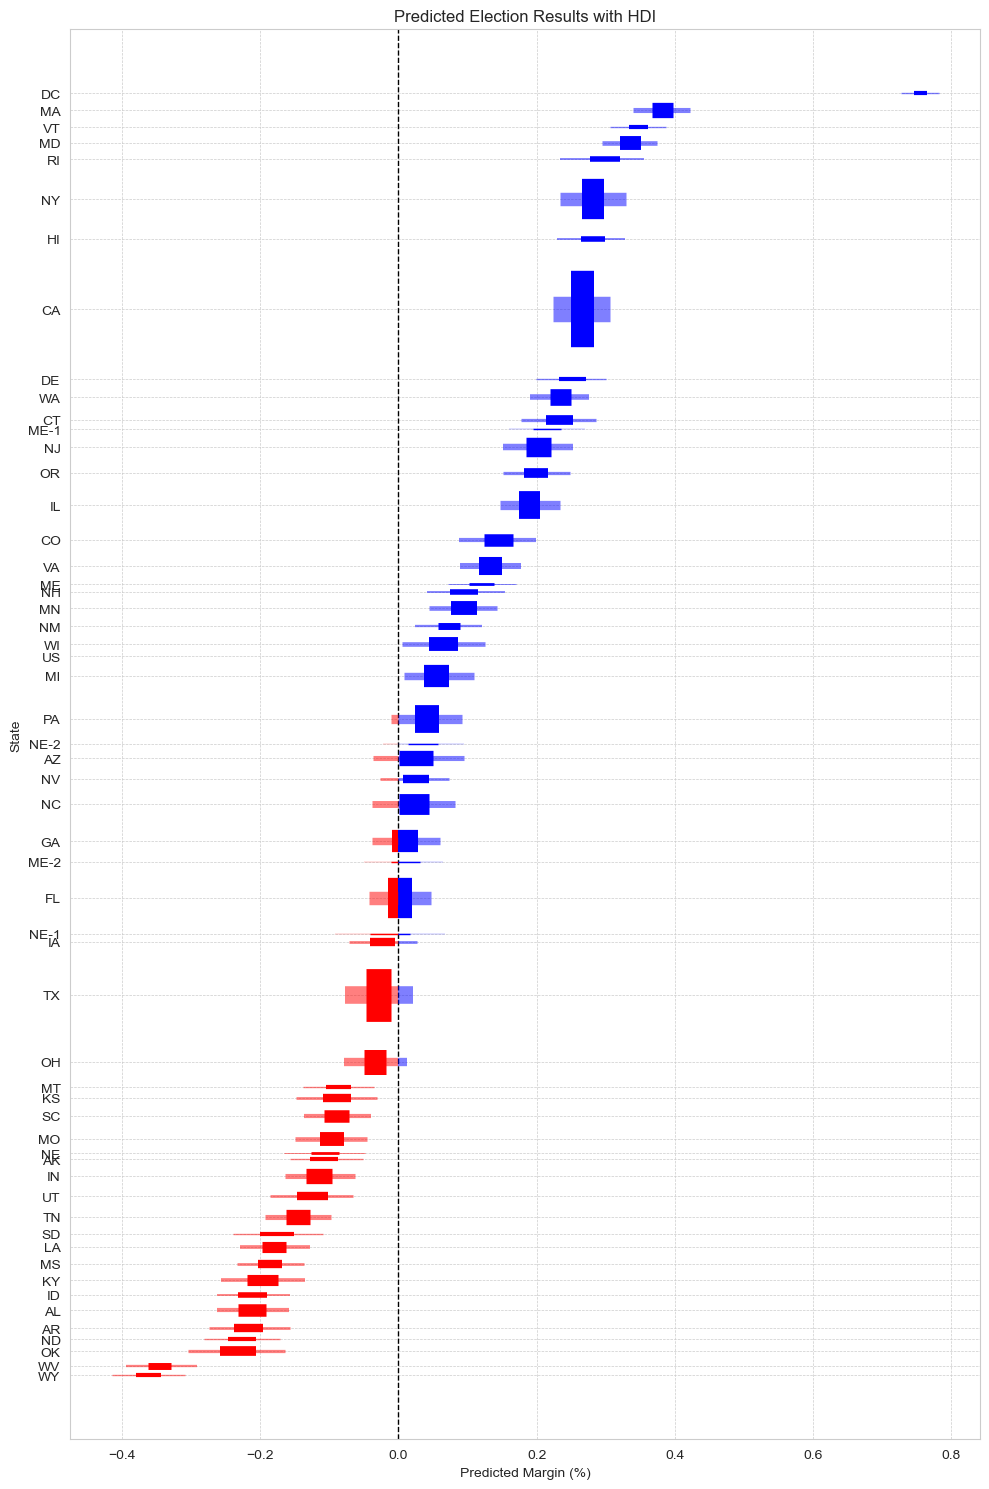

In [141]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2020'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2020'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 15))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

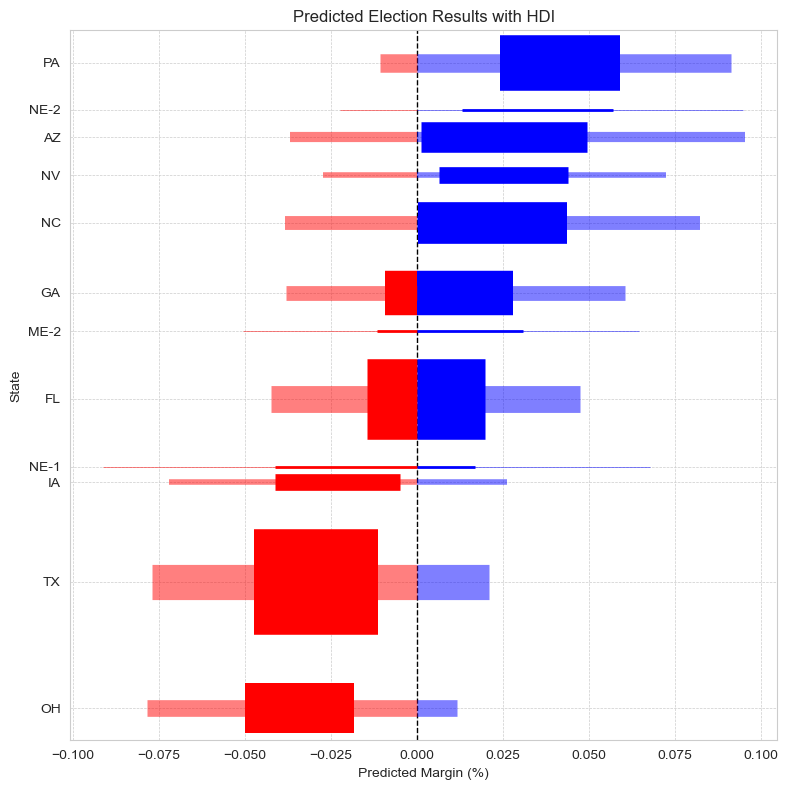

In [142]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('OH', 'TX', 'IA', 'NE-1', 'FL', 'ME-2', 'GA', 'NC', 'NV', 'AZ', 'NE-2', 'PA')").sort_values(by='hdi_mean')
scale_factor = 2

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2020'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2020'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(8, 8))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2020'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2020'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')

In [143]:
pollster_output = pd.DataFrame(columns=['pollster', 'dem_pollster_effect', 'gop_pollster_effect'])
pollster_output.pollster = pd.DataFrame(idata.posterior['dem_pollster_effect'].coords['pollster'])
pollster_output.dem_pollster_effect = pd.DataFrame(idata.posterior['dem_pollster_effect'].mean(axis=(0, 1)))
pollster_output.gop_pollster_effect = pd.DataFrame(idata.posterior['gop_pollster_effect'].mean(axis=(0, 1)))
pollster_output = pollster_output.merge(pd.DataFrame(df.pollster.value_counts()).reset_index(), on='pollster')

In [144]:
pollster_output.sort_values('count', ascending=False).head(10)

,pollster,dem_pollster_effect,gop_pollster_effect,count
180,SurveyMonkey,0.086636,0.187670,2840
123,Morning Consult,0.029932,0.049362,466
206,USC Dornsife,0.060271,0.116286,214
93,Ipsos,-0.107450,0.076543,187
229,YouGov,-0.023524,0.037111,156
27,Change Research,0.043752,0.036937,110
46,Data for Progress,0.128946,0.119734,96
157,Redfield & Wilton Strategies,-0.029351,-0.050064,94
138,PPP,0.093053,0.011985,91
184,TIPP,-0.001999,0.044959,69


In [145]:
method_output = pd.DataFrame(columns=['methodology', 'dem_method_effect', 'gop_method_effect'])
method_output.methodology = pd.DataFrame(idata.posterior['dem_method_effect'].coords['method'])
method_output.dem_method_effect = pd.DataFrame(idata.posterior['dem_method_effect'].mean(axis=(0, 1)))
method_output.gop_method_effect = pd.DataFrame(idata.posterior['gop_method_effect'].mean(axis=(0, 1)))
method_output = method_output.merge(pd.DataFrame(df.methodology.value_counts()).reset_index(), on='methodology')

In [146]:
method_output.sort_values('count', ascending=False).head(10)

,methodology,dem_method_effect,gop_method_effect,count
22,Online Panel,0.003677,-0.090051,4006
12,Live Phone,-0.009492,0.012355,728
26,Probability Panel,0.034799,-0.187246,411
9,IVR/Text,0.013045,-0.015213,117
14,Live Phone/Online Panel,0.002237,-0.018260,111
7,IVR/Online Panel,0.003926,-0.070002,109
30,Text-to-Web/Online Ad,-0.029248,-0.050317,106
21,Online Ad,0.064688,-0.104546,57
25,Online Panel/Text-to-Web,-0.114638,-0.152466,50
23,Online Panel/Online Ad,0.060888,-0.057895,50


In [147]:
population_output = pd.DataFrame(columns=['population', 'dem_pop_effect', 'gop_pop_effect'])
population_output.population = pd.DataFrame(idata.posterior['dem_pop_effect'].coords['population'])
population_output.dem_pop_effect = pd.DataFrame(idata.posterior['dem_pop_effect'].mean(axis=(0, 1)))
population_output.gop_pop_effect = pd.DataFrame(idata.posterior['gop_pop_effect'].mean(axis=(0, 1)))
population_output = population_output.merge(pd.DataFrame(df.population.value_counts()).reset_index(), on='population')

In [148]:
population_output.sort_values('count', ascending=False).head(10)

,population,dem_pop_effect,gop_pop_effect,count
1,lv,-0.030131,-0.262134,3550
2,rv,-0.022864,-0.317454,2238
0,a,-0.131072,-0.417450,166
3,v,-0.064394,-0.271362,82


In [149]:
state_output = pd.DataFrame(columns=['state', 'dem_state_effect', 'gop_state_effect'])
state_output.state = pd.DataFrame(idata.posterior['dem_state_effect'].coords['state'])
state_output.dem_state_effect = pd.DataFrame(idata.posterior['dem_state_effect'].mean(axis=(0, 1)))
state_output.gop_state_effect = pd.DataFrame(idata.posterior['gop_state_effect'].mean(axis=(0, 1)))
state_output = state_output.merge(pd.DataFrame(df.state.value_counts()).reset_index(), on='state')

In [150]:
state_output.sort_values('count', ascending=False).head(10)

,state,dem_state_effect,gop_state_effect,count
48,US,0.035489,-0.032971,1593
53,WI,0.068114,-0.109285,338
42,PA,0.018190,-0.015495,234
24,MI,0.030545,-0.067887,222
29,NC,-0.005332,-0.015652,212
9,FL,-0.085151,0.113862,207
3,AZ,-0.000818,-0.039887,188
47,TX,-0.147959,0.154286,138
10,GA,-0.053174,0.059619,134
39,OH,-0.158305,0.186895,105


In [151]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_ec[['dem_ec','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['us_margin'] = df_dem.US-df_gop.US

grouped_df = df_winp.groupby(list(df_winp.columns[1:-1])).agg(
    count=('us_margin', 'size'),   # Count the occurrences of each unique combination of rows
    margin_mean=('us_margin', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)
grouped_df.to_excel('df_value_counts.xlsx', index=False)

def conditional_probability(df, col_A, col_B):
    # Joint probability of A and B both being true (P(A ∩ B))
    P_A_and_B = ((df[col_A] == 1) & (df[col_B] == 1)).mean()
    
    # Probability of B being true (P(B))
    P_B = (df[col_B] == 1).mean()
    
    # Conditional probability P(A | B)
    return P_A_and_B / P_B if P_B != 0 else 0

# Create a table of conditional probabilities for each pair of columns
conditional_prob_table = pd.DataFrame(index=df_winp.iloc[:, :-2].columns, columns=df_winp.iloc[:, :-2].columns)

for col_A in df_winp.iloc[:, :-3].columns:
    for col_B in df_winp.iloc[:, :-2].columns:
        conditional_prob_table.loc[col_A, col_B] = conditional_probability(df_winp.iloc[:, :-2], col_A, col_B)

# Convert to float for easier viewing
conditional_prob_table = conditional_prob_table.astype(float)

selected_states = ['dem_ec', 'IA', 'FL', 'ME-2', 'GA','AZ','NC','NV','PA','WI','MI','DE', 'VA']

conditional_prob_table.loc[selected_states, selected_states]

,dem_ec,IA,FL,ME-2,GA,AZ,NC,NV,PA,WI,MI,DE,VA
dem_ec,1.000000,1.000000,1.000000,0.993740,0.995268,0.996053,0.993369,0.983668,0.994658,0.955193,0.955420,0.943,0.943
IA,0.204666,1.000000,0.321168,0.291080,0.291798,0.248684,0.251989,0.236181,0.206197,0.196538,0.195542,0.193,0.193
FL,0.581124,0.911917,1.000000,0.691706,0.705047,0.644737,0.637931,0.631910,0.580128,0.557026,0.555218,0.548,0.548
ME-2,0.673383,0.963731,0.806569,1.000000,0.799685,0.760526,0.767905,0.738693,0.676282,0.649695,0.647416,0.639,0.639
GA,0.669141,0.958549,0.815693,0.793427,1.000000,0.775000,0.763926,0.731156,0.670940,0.642566,0.641337,0.634,0.634
AZ,0.802757,0.979275,0.894161,0.904538,0.929022,1.000000,0.888594,0.847990,0.803419,0.773931,0.770010,0.760,0.760
NC,0.794274,0.984456,0.877737,0.906103,0.908517,0.881579,1.000000,0.858040,0.794872,0.766802,0.763931,0.754,0.754
NV,0.830329,0.974093,0.917883,0.920188,0.917981,0.888158,0.905836,1.000000,0.830128,0.809572,0.802432,0.796,0.796
PA,0.987275,1.000000,0.990876,0.990610,0.990536,0.989474,0.986737,0.976131,1.000000,0.946029,0.945289,0.936,0.936
WI,0.994698,1.000000,0.998175,0.998435,0.995268,1.000000,0.998674,0.998744,0.992521,1.000000,0.987842,0.982,0.982


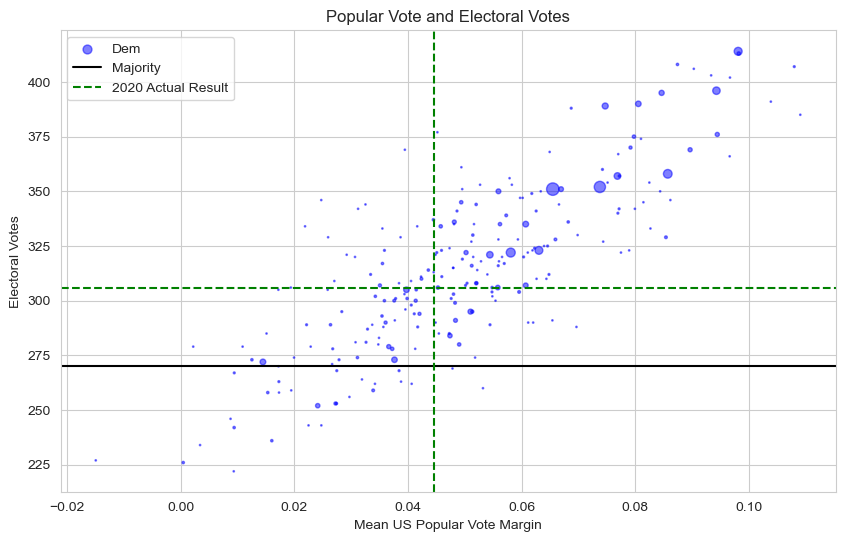

In [325]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(grouped_df['margin_mean'], grouped_df['dem'], 
            s=grouped_df['count'], color='blue', alpha=0.5, label='Dem')

plt.axhline(y=270, color='black', linestyle='-', label='Majority')

plt.axhline(y=306, color='green', linestyle='--', label='2020 Actual Result')
plt.axvline(x=.0446, color='green', linestyle='--')

ax.set_ylim(0,538)

# Add labels and title
plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Votes')
plt.title('Popular Vote and Electoral Votes')

# Add legend
plt.legend()

# Show plot
plt.show()

In [329]:
df_winp.us_margin

,US,FL,IA,PA,NV,GA,SC,NE-2,MT,ME,...,CO,CA,AR,AL,AK,NE-1,dem_ec,dem,gop,us_margin
0,1,0,0,1,1,1,0,1,0,1,...,1,1,0,0,0,0,1,311,227,0.052570
1,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,0,0,1,305,233,0.038880
2,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,0,0,1,305,233,0.050371
3,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,0,0,1,291,247,0.063562
4,1,0,0,1,1,0,0,1,0,1,...,1,1,0,0,0,0,1,295,243,0.072538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,1,1,1,0,1,0,1,...,1,1,0,0,0,0,1,351,187,0.064321
996,1,1,0,1,1,1,0,1,0,1,...,1,1,0,0,0,0,1,389,149,0.052815
997,1,0,0,1,1,1,0,1,0,1,...,1,1,0,0,0,1,1,322,216,0.046382
998,1,1,0,1,1,1,0,1,0,1,...,1,1,0,0,0,0,1,351,187,0.076242


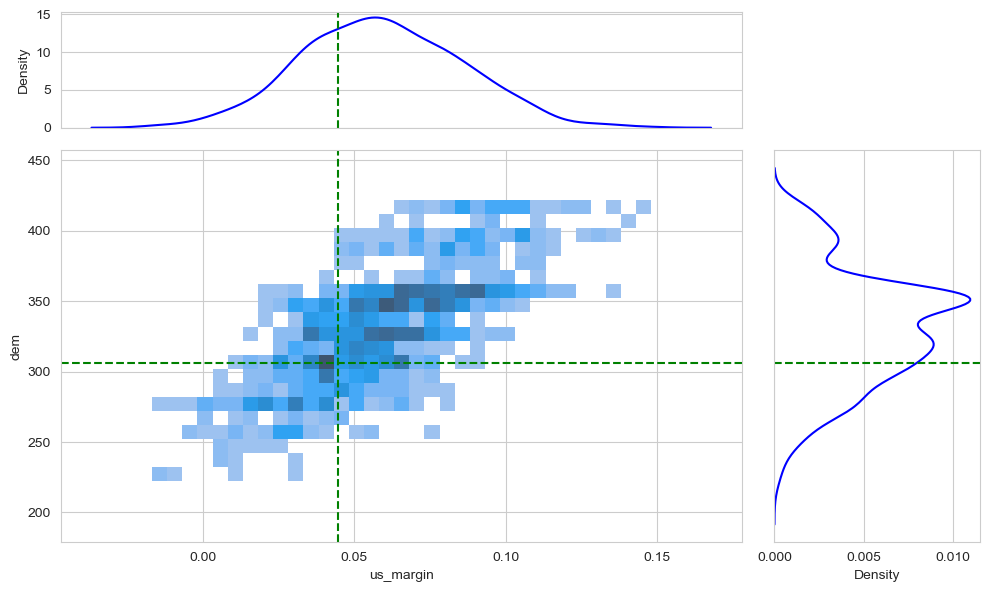

In [354]:
from matplotlib.gridspec import GridSpec

# Example Data (replace df_winp with your actual dataframe)
# df_winp = ...

# Create the figure with subplots
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 4, figure=fig)

# Main 2D histogram (place at center)
ax_main = fig.add_subplot(gs[1:4, 0:3])
sns.histplot(x=df_winp.us_margin, y=df_winp.dem, binwidth=(.005,10), ax=ax_main)
ax_main.axhline(y=306, color='green', linestyle='--', label='2020 Actual Result')
ax_main.axvline(x=.0446, color='green', linestyle='--')

# KDE on top (for us_margin)
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
sns.kdeplot(x=df_winp.us_margin, ax=ax_top, color='blue')
ax_top.axvline(x=.0446, color='green', linestyle='--')  # Extend vertical dashed line to top KDE
ax_top.get_xaxis().set_visible(False)  # Hide x-axis labels

# KDE on the right (for dem)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
sns.kdeplot(y=df_winp.dem, ax=ax_right, color='blue')
ax_right.axhline(y=306, color='green', linestyle='--')  # Extend horizontal dashed line to right KDE
ax_right.get_yaxis().set_visible(False)  # Hide y-axis labels

# Adjust layout
plt.tight_layout()

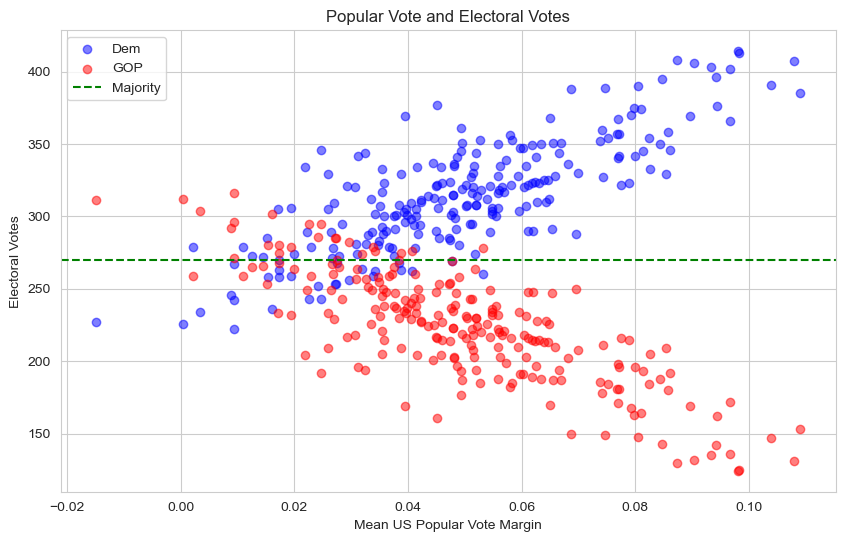

In [153]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(grouped_df['margin_mean'], grouped_df['dem'], 
            color='blue', alpha=0.5, label='Dem')

# Plot 'gop' on the y-axis
plt.scatter(grouped_df['margin_mean'], grouped_df['gop'], 
            color='red', alpha=0.5, label='GOP')

plt.axhline(y=270, color='green', linestyle='--', label='Majority')

ax.set_ylim(0,538)

# Add labels and title
plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Votes')
plt.title('Popular Vote and Electoral Votes')

# Add legend
plt.legend()

# Show plot
plt.show()

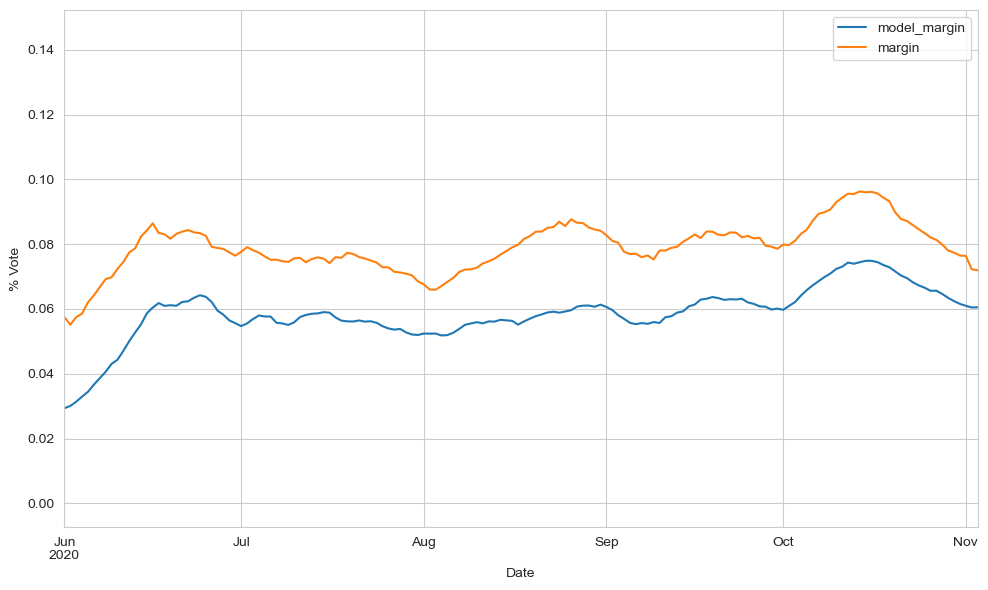

In [154]:
graph_state = 'US'


df_post = pd.DataFrame()
df_post['Date'] = pd.date_range(start=df.date.min(), end='2020-11-04')
df_post = df_post.set_index('Date')
df_post['model_margin'] = df_day_mean[f"{graph_state}_margin"].values

df_post = pd.merge(df_post, df.query(f"state == '{graph_state}'")[['date','margin']].groupby('date').mean(),
         how="left",
         left_index=True,
         right_index=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot rolling mean on the provided axis
df_post.rolling('14d').mean().plot(ax=ax)

# Set limits and labels
#ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2020, 6, 1), dt.datetime(2020, 11, 3))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

# Set the legend for better understanding of the lines
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [155]:
df_2020 = pd.read_csv("../Data/clean/2020_election_results.csv")

In [156]:
df_margin = pd.merge(df_margin, df_2020[['State','margin']],
         how="left",
         left_on='state_code',
         right_on='State').drop(columns='state_code')

df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='State',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2536857599.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2536857599.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


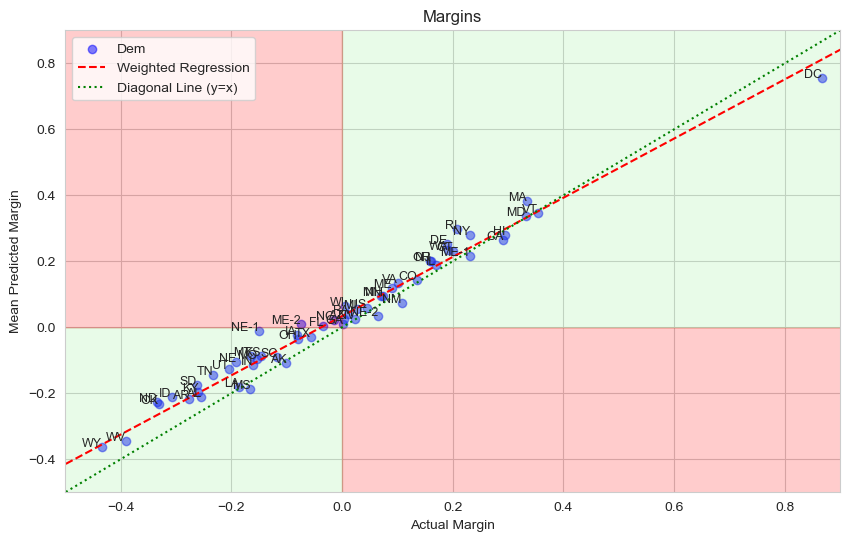

In [186]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['hdi_mean']
weights = df_margin['electoral_2020']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle=':', label='Diagonal Line (y=x)')

ax.set_xlim(-.5, .9)
ax.set_ylim(-.5, .9)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3603397799.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3603397799.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


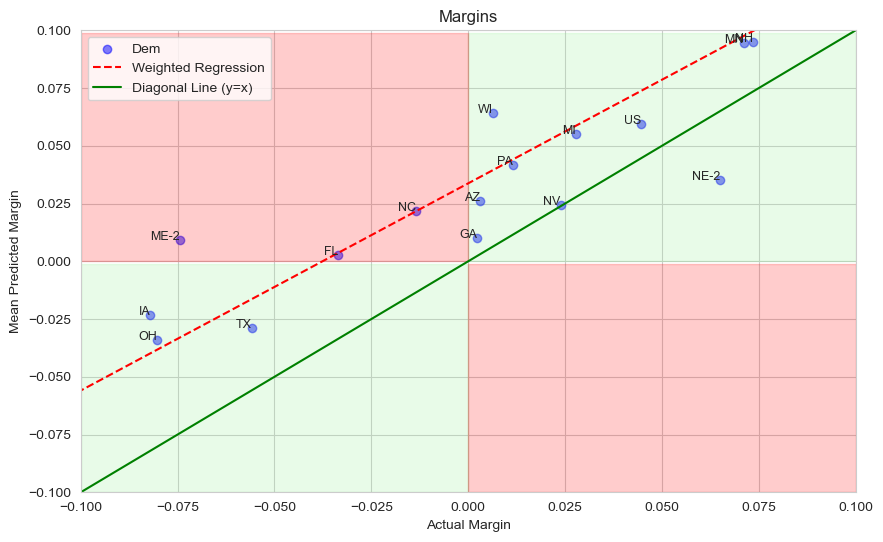

In [187]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['hdi_mean']
weights = df_margin['electoral_2020']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=0, x2=0.1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=-0.1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=-0.1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=0, x2=0.1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

In [189]:
calc_slope = 1/slope
calc_intercept = intercept

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3584677841.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3584677841.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


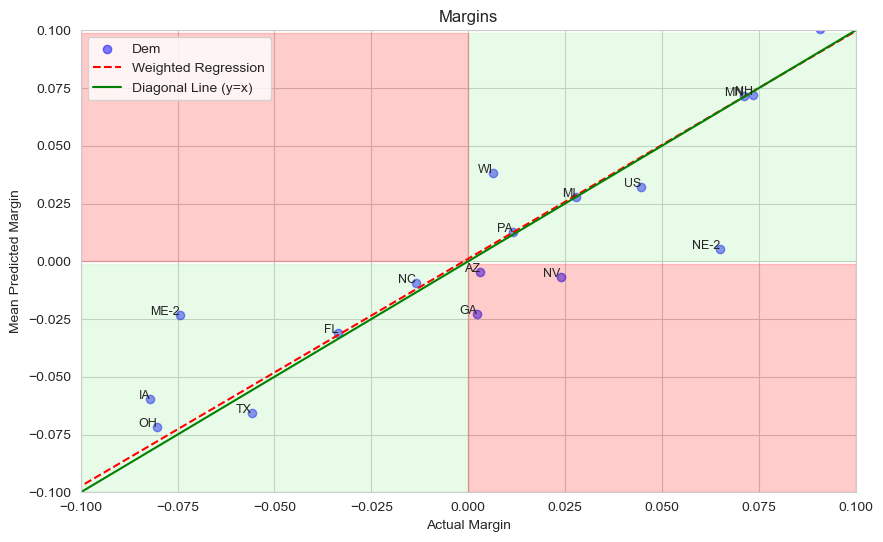

In [192]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], (df_margin['hdi_mean']*calc_slope-calc_intercept), 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = (df_margin['hdi_mean']*calc_slope-calc_intercept)
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=0, x2=0.1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=-0.1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=-0.1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=0, x2=0.1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = (df_margin['hdi_mean']*calc_slope-calc_intercept)[i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], (df_margin['hdi_mean']*calc_slope-calc_intercept)[i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2308694368.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2308694368.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


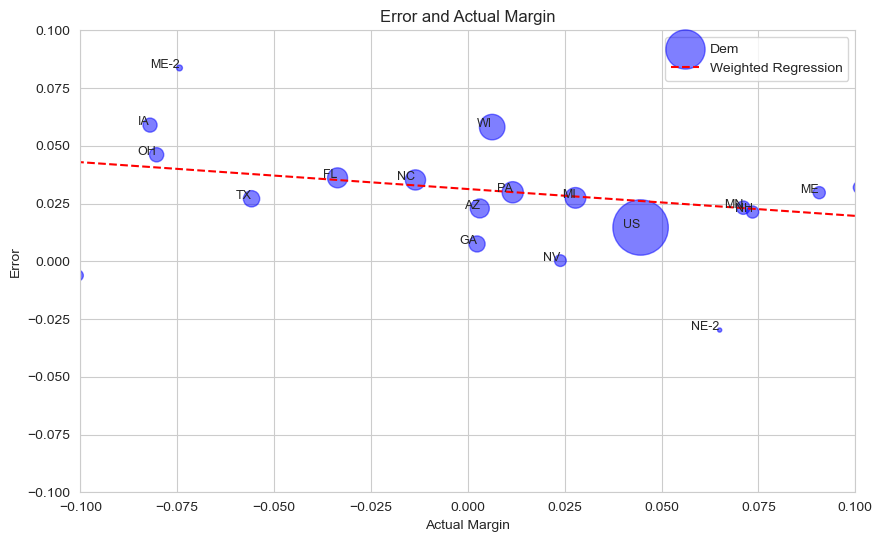

In [322]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error'], 
            s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/311492569.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/311492569.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


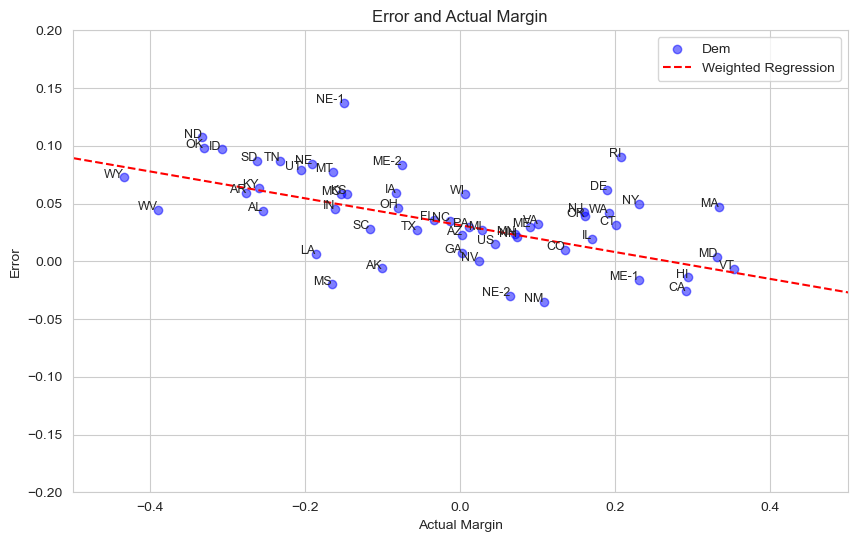

In [324]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error'], 
            color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .5)
ax.set_ylim(-.2, .2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

In [323]:
slope

-0.11627208360242697

In [166]:
df_margin['mean_corrected'] = df_margin.hdi_mean*1.1352363902321996-0.03165951666845333
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2039625265.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/2039625265.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


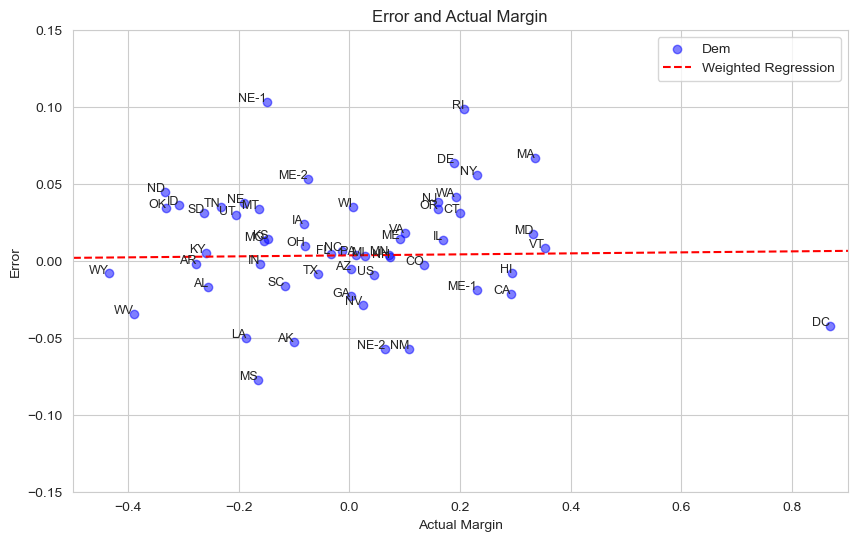

In [167]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
            color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error_corrected']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(-.5, .9)
ax.set_ylim(-.15, .15)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

In [168]:
slope

0.0032400897586039095

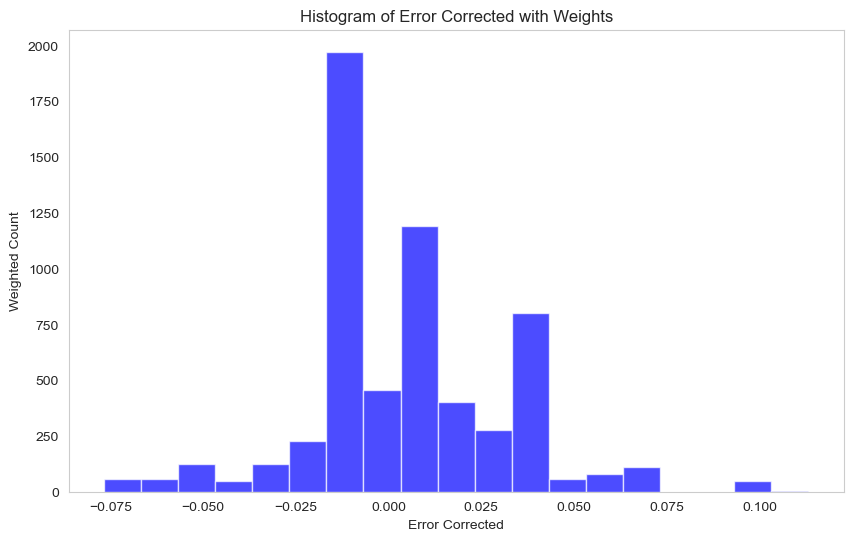

In [169]:
# Create the histogram
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], weights=df_margin['count'], bins=bins, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Error Corrected')
plt.ylabel('Weighted Count')
plt.title('Histogram of Error Corrected with Weights')
plt.grid()

# Show the plot
plt.show()

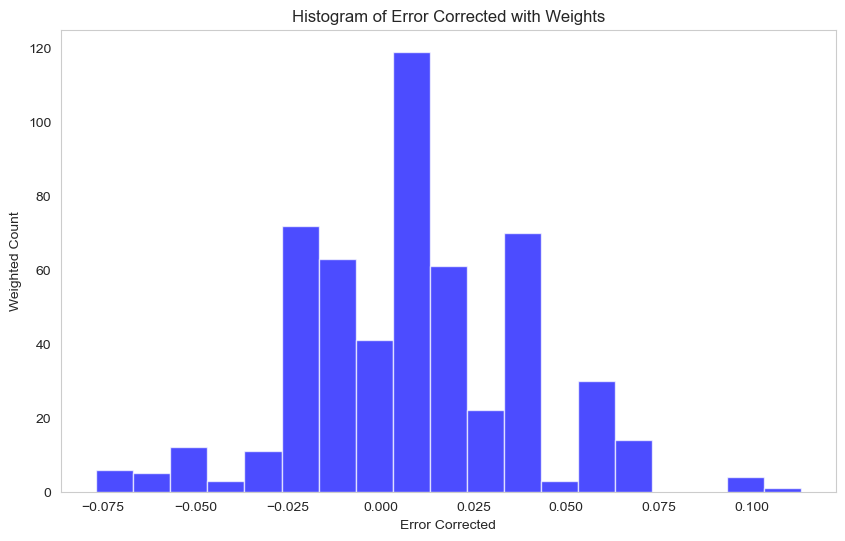

In [170]:
# Create the histogram
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], weights=df_margin['electoral_2020'], bins=bins, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Error Corrected')
plt.ylabel('Weighted Count')
plt.title('Histogram of Error Corrected with Weights')
plt.grid()

# Show the plot
plt.show()

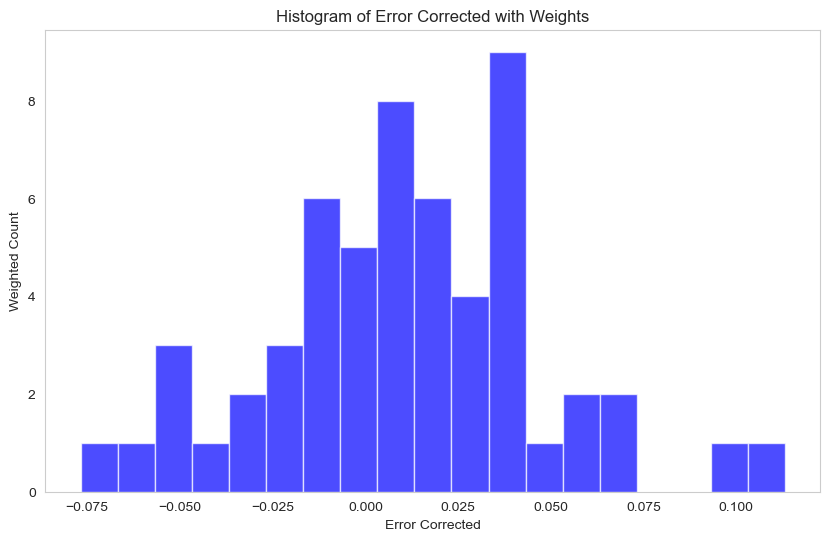

In [171]:
# Create the histogram
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], bins=bins, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Error Corrected')
plt.ylabel('Weighted Count')
plt.title('Histogram of Error Corrected with Weights')
plt.grid()

# Show the plot
plt.show()

<Axes: >

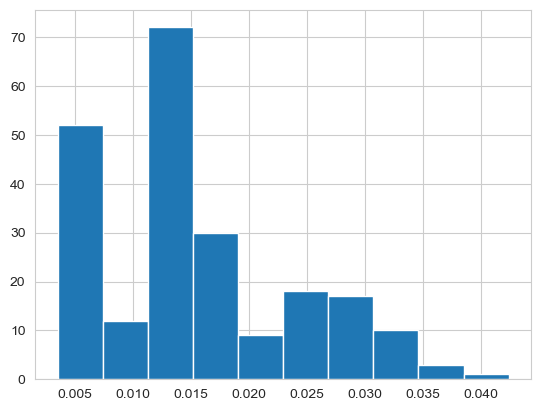

In [172]:
df_results.std().hist()

In [173]:
#polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, .034, dims="state")

In [174]:
inv_logit(df_margin['error_corrected']).std()

0.00908483983224374

In [175]:
(inv_logit(interim['fund_dem']-interim['fund_gop'])).std()

0.022247412697071357

In [176]:
np.sqrt(0.030**2 - 0.024**2)

0.018

In [177]:
(
  inv_logit(idata.posterior["dem_state_effect"].sel(state="GA").values
           + idata.posterior["dem_state_multi"].sel(state="GA").values * 0)
 -inv_logit(idata.posterior["gop_state_effect"].sel(state="GA").values
           + idata.posterior["gop_state_multi"].sel(state="GA").values * .1)
).std()

0.008416807964989802

In [178]:
np.sqrt(0.035**2 - 0.0087**2)

0.03390147489416943

In [285]:
df_sample = (df_dem - df_gop).sample(n=1).transpose().reset_index()
df_sample.rename(columns={df_sample.columns[0]: 'state', df_sample.columns[1]: 'sample_margin'}, inplace=True)

df_sample = pd.merge(df_sample, df_2020[['State','margin']],
         how="left",
         left_on='state',
         right_on='State').drop(columns='state')

df_sample['error'] =  df_sample.sample_margin - df_sample.margin

df_sample = pd.merge(df_sample, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='State',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3674511308.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3674511308.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


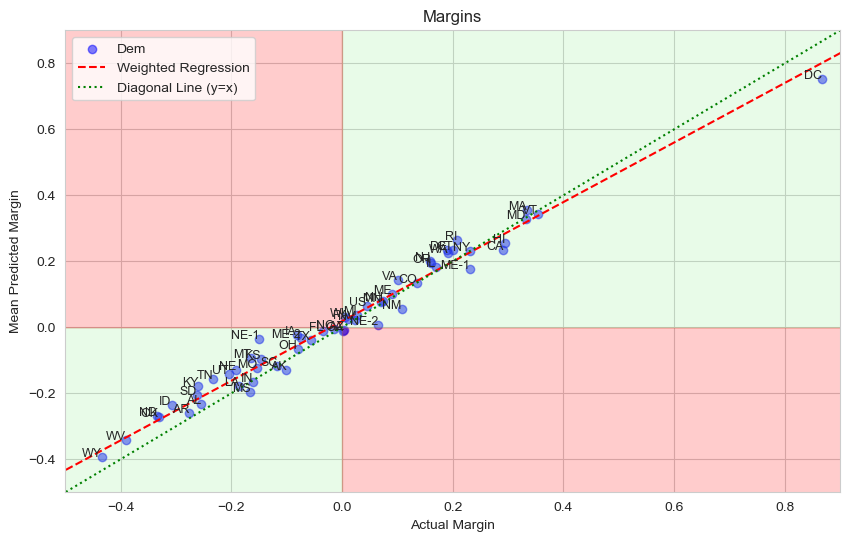

In [286]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_sample['margin'], df_sample['sample_margin'], 
            color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_sample['margin']
y = df_sample['sample_margin']
weights = df_sample['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle=':', label='Diagonal Line (y=x)')

ax.set_xlim(-.5, .9)
ax.set_ylim(-.5, .9)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_sample['State']):
    x_val = df_sample['margin'][i]
    y_val = df_sample['sample_margin'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_sample['margin'][i], df_sample['sample_margin'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

In [287]:
calc_slope = 1/slope
calc_intercept = intercept

In [288]:
calc_slope

1.107746493864632

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3517852176.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/3517852176.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


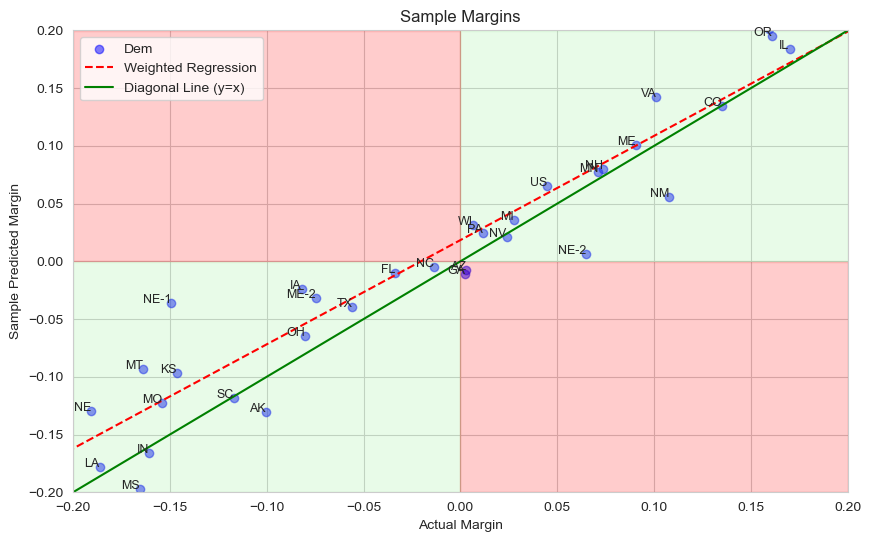

In [294]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_sample['margin'], df_sample['sample_margin'], 
            color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_sample['margin']
y = df_sample['sample_margin']
weights = df_sample['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

resolution = 0.2

ax.set_xlim(-resolution, resolution)
ax.set_ylim(-resolution, resolution)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, resolution, 0.001), x1=0, x2=resolution, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-resolution, 0, 0.001), x1=-resolution, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, resolution, 0.001), x1=-resolution, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-resolution, 0, 0.001), x1=0, x2=resolution, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_sample['margin'][i]
    y_val = df_sample['sample_margin'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_sample['margin'][i], df_sample['sample_margin'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Sample Predicted Margin')
plt.title('Sample Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/4059755754.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_26922/4059755754.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


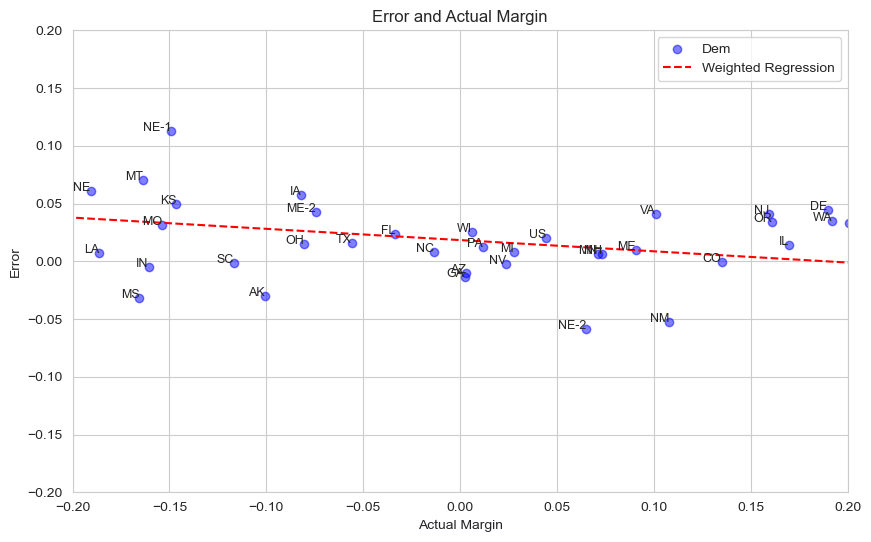

In [296]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_sample['margin'], df_sample['error'], 
            color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_sample['margin']
y = df_sample['error']
weights = df_sample['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.2, .2)
ax.set_ylim(-.2, .2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_sample['State']):
    x_val = df_sample['margin'][i]
    y_val = df_sample['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_sample['margin'][i], df_sample['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()